In [2]:
# coding: utf8
import tensorflow as tf
import matplotlib as mp
from konlpy.tag import Hannanum

In [3]:
GO = '<GO>'
EOD = '<EOD>'
PAD = '<PAD>'

In [3]:

import spacy
nlp = spacy.load("en_core_web_lg")


In [115]:
data = "./../kor-eng/kor.txt"
texts = open(data, mode='rt', encoding='utf-8-sig').read().split("\n")

pair_kor=[]
pair_eng=[]
KMA = Hannanum()

for text in texts:
    pair = text.split("\t")
    if len(pair)==2:
        kor = KMA.pos(pair[1])
        tmp = []
        for p in kor:            
            tmp.append (p[0]+"/"+p[1])
        pair_kor.append(tmp+[EOD])
        pair_eng.append(KMA.morphs(pair[0])+[EOD])
    else:
        continue
    
    
    
assert len(pair_kor)==len(pair_eng)
print(pair_kor[0])
print(pair_eng[0])

['누구/N', '?/S', '<EOD>']
['Who', '?', '<EOD>']


In [116]:
import pickle
with open("./translation_preprocessed.p", 'wb') as out_file:
    pickle.dump( (pair_eng, pair_kor), out_file)


In [4]:
import pickle
def load_preprocess():
    preprocess_file = "./translation_preprocessed.p"
    print(preprocess_file)
    with open(preprocess_file, mode='rb') as in_file:
        return pickle.load(in_file)
    
(pair_eng, pair_kor) = load_preprocess()
assert (len(pair_eng) == len(pair_kor))

./translation_preprocessed.p


In [5]:
voca_eng = set()
for sent in pair_eng:
    for w in sent:
        voca_eng.add(w)

voca_kor = set()        
for sent in pair_kor:
    for w in sent:
        voca_kor.add(w)

In [6]:
print([v for i, v in enumerate(voca_kor)][:10])
print([v for i, v in enumerate(voca_eng)][:10])

['을/E', '끝내/P', '꽃/N', '줄거/N', '열/P', '시겠어/E', '직접/M', '생일/N', '게/J', '없이/M']
['Whose', 'repeat', 'bad', 'Come', 'into', 'originated', 'works', 'tend', 'bike', 'services']


In [7]:
voca_k_to_int = {c: i+2 for i, c in enumerate(voca_kor)}
voca_e_to_int = {c: i+2 for i, c in enumerate(voca_eng)}


voca_k_to_int[GO] = 1
voca_k_to_int[PAD] = 0

voca_e_to_int[PAD] = 0
voca_e_to_int[GO] = 1

int_to_voca_k = {}
int_to_voca_e = {}

for v in voca_k_to_int:
    i = voca_k_to_int[v]
    int_to_voca_k[i] = v
    
for v in voca_e_to_int:
    i = voca_e_to_int[v]
    int_to_voca_e[i] = v    
    
print(voca_k_to_int[PAD], voca_k_to_int[GO], voca_k_to_int[EOD])
print(voca_e_to_int[PAD], voca_e_to_int[EOD])

0 1 957
0 920


In [8]:
source_sent_ids = [[voca_e_to_int[v] for v in sent] for sent in pair_eng]
target_sent_ids = [[voca_k_to_int[v] for v in sent] for sent in pair_kor]

In [9]:
print(pair_eng[0:3], source_sent_ids[0:3])
print(pair_kor[0:3], target_sent_ids[0:3])

[['Who', '?', '<EOD>'], ['Hello', '!', '<EOD>'], ['No', 'way', '!', '<EOD>']] [[166, 573, 920], [377, 1101, 920], [899, 1087, 1101, 920]]
[['누구/N', '?/S', '<EOD>'], ['안녕/I', '!/S', '<EOD>'], ['절대/M', '아니/P', '야/E', './S', '<EOD>']] [[683, 421, 957], [295, 238, 957], [1024, 491, 539, 256, 957]]


In [10]:
# Number of Epochs
epochs = 200
# Batch Size
batch_size = 4
# RNN Size
rnn_size = 512
rnn_size_dec=rnn_size

# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 128
decoding_embedding_size = 128
# Learning Rate
learning_rate = 0.001
keep_prob=0.6
beam_width=1

In [11]:
tf.reset_default_graph()
def get_model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
    max_target_sequence_length = tf.reduce_max(target_sequence_length, name='max_target_len')
    source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
    
    return input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length

In [12]:
from tensorflow.contrib import rnn
from tensorflow.contrib.rnn import LSTMStateTuple

def encoding_layer(input_data, rnn_size, num_layers, source_sequence_length, source_vocab_size):
    
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size,
                                                       encoding_embedding_size)
    def make_cell(rnn_size):
        enc_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                          initializer=tf.contrib.layers.xavier_initializer())#initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return enc_cell
    
    fw_cell = tf.contrib.rnn.MultiRNNCell( [make_cell(rnn_size) for _ in range(num_layers)])
    fw_drop_enc_cell = tf.contrib.rnn.DropoutWrapper (fw_cell, output_keep_prob=keep_prob)
    
    bw_cell = tf.contrib.rnn.MultiRNNCell( [make_cell(rnn_size) for _ in range(num_layers)])
    bw_drop_enc_cell = tf.contrib.rnn.DropoutWrapper( bw_cell, output_keep_prob=keep_prob)
    
    
    bi_output, bi_enc_state = tf.nn.bidirectional_dynamic_rnn(fw_drop_enc_cell,
                                                             bw_drop_enc_cell,
                                                             enc_embed_input,
                                                             sequence_length=source_sequence_length,
                                                             dtype=tf.float32)
    enc_output = tf.concat(bi_output, -1)
    
    if num_layers == 1:
        enc_fw_state = bi_enc_state[0]
        enc_bw_state = bi_enc_state[1]
        
    else:
        enc_fw_state = bi_enc_state[0][-1]
        enc_bw_state = bi_enc_state[1][-1]
        
    c_forward = enc_fw_state.c
    h_forward = enc_fw_state.h
    c_backward = enc_bw_state.c
    h_backward = enc_bw_state.h
    c_last = tf.concat( (c_forward, c_backward ), -1)
    h_last = tf.concat( (h_forward, h_backward ), -1)
    
    enc_state= []
    for i in range(num_layers):
        c_decoder = tf.layers.dense(inputs=c_last, units=rnn_size, use_bias=True,activation=None, 
                                    kernel_initializer=tf.truncated_normal_initializer(),
                                   name='encoder_c_state_projection_layer{}'.format(i))
        h_decoder = tf.layers.dense(inputs=h_last, units=rnn_size, use_bias=True,activation=None,
                                   kernel_initializer=tf.truncated_normal_initializer(),
                                   name='encoder_h_state_projection_layer{}'.format(i))
        decoder_state = tf.contrib.rnn.LSTMStateTuple(c=c_decoder, h=h_decoder)
        enc_state.append(decoder_state)
        
    enc_state = tuple(enc_state) if len(enc_state)>1 else enc_state[0]
    
    return enc_output, enc_state           
        
    

In [13]:
def process_decoder_input(target, vocab_to_int, batch_size):
    ending = tf.strided_slice(target, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat( [tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)
    
    return dec_input

from tensorflow.python.layers.core import Dense

def decoding_layer (target_vocab_to_int, decoding_embedding_size, num_layers, rnn_size,
                   source_sequence_length, target_sequence_length, max_target_sequence_length,
                   enc_state, dec_input, enc_output, beam_width):
    
    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    
    #Add attention
    with tf.variable_scope('shared_attention_mechanism'):
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=rnn_size, 
                                                                memory=enc_output,
                                                                memory_sequence_length=source_sequence_length)
    
    def make_cell(rnn_size):
        dec_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                          initializer=tf.contrib.layers.xavier_initializer())#tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return dec_cell
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([ make_cell(rnn_size) for _ in range(num_layers)])
    attn_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism,
                                                    attention_layer_size=rnn_size,
                                                    alignment_history=True)
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                       sequence_length=target_sequence_length,
                                                       time_major=False)
    
    projection_layer = Dense(target_vocab_size, use_bias=False, kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_cell, training_helper,
                                                      attn_cell.zero_state(batch_size=batch_size, dtype=tf.float32).clone(cell_state=enc_state),
                                                      output_layer=projection_layer)
    
    with tf.variable_scope('decode_with_shared_attention'):
        training_decoder_output, training_decoder_state, _ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                                              impute_finished=True,
                                                                                              maximum_iterations = max_target_sequence_length)
        
    #beam search
    
    #X_seq_len = tf.contrib.seq2seq.tile_batch(source_sequence_length, multiplier=beam_width)
    
    
    start_words = tf.tile(tf.constant([target_vocab_to_int[GO]], dtype=tf.int32), [batch_size], name='start_words')
    
    with tf.variable_scope('shared_attention_mechanism', reuse=True):
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(num_units=rnn_size,
                                                               memory=enc_output,
                                                               memory_sequence_length=source_sequence_length)
    
    dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    attn_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism, 
                                                    attention_layer_size=rnn_size,
                                                    alignment_history=True)
    
    encoder_state = attn_cell.zero_state(batch_size=batch_size, dtype=tf.float32).clone(cell_state=enc_state)
    #decoder_initial_state = tf.contrib.seq2seq.tile_batch(encoder_state, multiplier=beam_width*batch_size)
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, start_words, target_vocab_to_int[EOD])
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(attn_cell, inference_helper, encoder_state, projection_layer)
    
    with tf.variable_scope('decode_with_shared_attention', reuse=True):
        inference_decoder_output, inference_decoder_state, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                                                                impute_finished=False,
                                                                                                maximum_iterations=max_target_sequence_length)
        
    return training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state
    

In [14]:
# to visualize attention weights
# https://stackoverflow.com/questions/44613173/how-to-visualize-attention-weights-from-attentionwrapper

In [15]:
def seq2seq_model(input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length,
                 rnn_size_dec, voca_target_to_int, num_layers, beam_width):
    
    target_vocab_size = len(voca_target_to_int)
    
    enc_output, enc_state = encoding_layer(input_data, rnn_size, num_layers, source_sequence_length, len(voca_target_to_int))
    
    dec_input = process_decoder_input(targets, voca_target_to_int, batch_size)
    
    training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state = decoding_layer(voca_target_to_int,
                                                                                                                       decoding_embedding_size,
                                                                                                                       num_layers,
                                                                                                                       rnn_size_dec,
                                                                                                                       source_sequence_length,
                                                                                                                       target_sequence_length,
                                                                                                                       max_target_sequence_length,                                                                                                                       
                                                                                                                       enc_state,
                                                                                                                       dec_input,
                                                                                                                       enc_output,
                                                                                                                       beam_width)

    
    return training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state

In [16]:
print(len(source_sent_ids))
print(source_sent_ids[0:2])
source_sent_ids = source_sent_ids[:batch_size*(len(source_sent_ids)//batch_size)]
target_sent_ids = target_sent_ids[:batch_size*(len(target_sent_ids)//batch_size)]
print(len(source_sent_ids))

909
[[166, 573, 920], [377, 1101, 920]]
908


In [28]:
#tf.reset_default_graph()
tf_graph = tf.Graph()
with tf_graph.as_default():
    input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length = get_model_inputs()

    
    
    training_decoder_output, training_decoder_state, inference_decoder_output, inference_decoder_state = seq2seq_model(input_data,
                                                                                                                      targets, learning_rate,
                                                                                                                       target_sequence_length, 
                                                                                                                       max_target_sequence_length,
                                                                                                                       source_sequence_length,                                                                                                                       
                                                                                                                       rnn_size_dec, 
                                                                                                                       voca_k_to_int,
                                                                                                                       num_layers,
                                                                                                                       beam_width)
    

    
    training_logits = tf.identity(training_decoder_output.rnn_output, 'logits')
    inference_logits = tf.identity(inference_decoder_output.sample_id, name='predictions')
    
    # the weights for sequence loss
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')
    
    with tf.name_scope("optimization"):
        '''
        def _sampled_loss(labels, logits):
            labels = tf.cast(labels, tf.int32)
            labels = tf.reshape(labels, [-1, 1])
            logits = tf.cast(logits, tf.float32)
            return tf.cast( tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels),tf.float32)
        
        softmax_loss_f = _sampled_loss
        cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                               targets,
                                               masks,
                                               softmax_loss_function=softmax_loss_f)
        '''
        cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks)        
        optimizer = tf.train.AdamOptimizer(lr)
        
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -2., 2.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
        

In [29]:
def pad_sentence_batch(sentence_batch, pad_id):
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_id] * (max_sentence - len(sentence)) for sentence in sentence_batch]

def get_batches(sources, targets, batch_size, s_pad_id, t_pad_id):
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size
        
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]
        
        pad_sources_batch = pad_sentence_batch(sources_batch, s_pad_id)
        pad_targets_batch = pad_sentence_batch(targets_batch, t_pad_id)
        
        
        source_lengths = []
        for source in sources_batch:
            source_lengths.append(len(source))
        
        targets_lengths = []
        for target in targets_batch:
            targets_lengths.append(len(target))
            
        yield pad_sources_batch, pad_targets_batch, source_lengths, targets_lengths
        
        

In [30]:
# -*- coding: utf-8 -*-
"""
Demo of unicode support in text and labels.
"""
from __future__ import unicode_literals
import numpy as np
import matplotlib.pyplot as plt


def my_plot(data, source_labels, target_labels):
    #ndata = (data - np.mean(data))/(np.max(data)-np.min(data))
    #ndata = ndata[::-1]
    ndata = data
    
    plt.rc('font', family='NanumGothic') 


    fig, ax = plt.subplots()
    heatmap = ax.pcolor(ndata, cmap = plt.cm.Blues)
    
    ax.set_xticks(np.arange(ndata.shape[1]) + 0.5, minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(np.arange(ndata.shape[0]) + 0.5, minor=False) # mma.shape[0] = input seq 길이
 
    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, int(ndata.shape[1]))
    ax.set_ylim(0, int(ndata.shape[0]))
 
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
 
    plt.xticks(rotation=45)
    
    cbaxes = fig.add_axes([0.2, 0, 0.6, 0.03])
    cbar = fig.colorbar(heatmap, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Normalized Alpha Scale', labelpad=2)
 
    # plt.tight_layout()
    plt.show()
    

[[[0.3335068  0.3333004  0.33319283 0.        ]
  [0.33327314 0.33334994 0.33337694 0.        ]
  [0.2503285  0.25003392 0.24984878 0.24978875]
  [0.2503285  0.25003392 0.24984878 0.24978875]]

 [[0.33342302 0.3333204  0.33325654 0.        ]
  [0.33327648 0.333353   0.33337054 0.        ]
  [0.25029004 0.25003588 0.24985477 0.24981934]
  [0.25029004 0.25003588 0.24985477 0.24981934]]

 [[0.33335057 0.3333366  0.33331284 0.        ]
  [0.33329684 0.33335552 0.33334762 0.        ]
  [0.25029114 0.25005984 0.24985339 0.2497956 ]
  [0.25029114 0.25005984 0.24985339 0.2497956 ]]

 [[0.3333032  0.33334658 0.33335018 0.        ]
  [0.3333369  0.33335862 0.3333045  0.        ]
  [0.25031066 0.25008464 0.24984679 0.2497579 ]
  [0.25031066 0.25008464 0.24984679 0.2497579 ]]]
input: Who ? <EOD>
gener: Who ? <EOD>


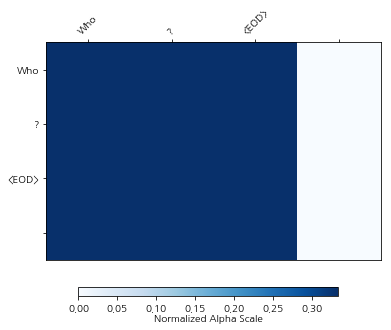

input: Hello ! <EOD>
gener: Hello ! <EOD>


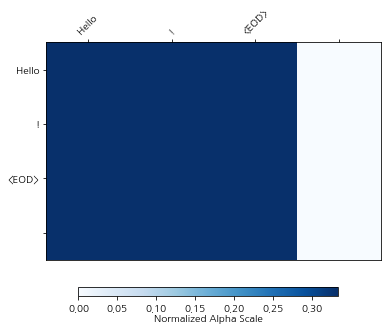

input: No way ! <EOD>
gener: No way ! <EOD>


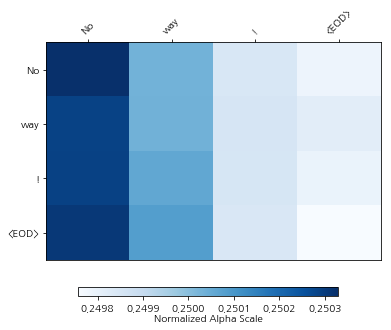

input: No way ! <EOD>
gener: No way ! <EOD>


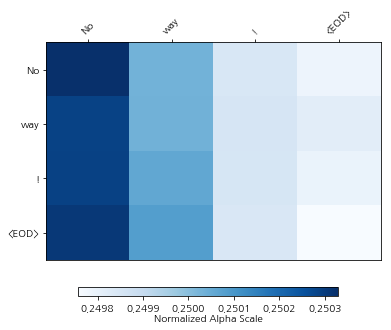

Epoch   0/200 Batch    0/227 - Loss:  7.144
[[[1.15324870e-01 1.64650321e-01 1.84454501e-01 1.62715018e-01
   1.33876473e-01 1.03234321e-01 7.71633312e-02 5.85811920e-02
   0.00000000e+00 0.00000000e+00]
  [8.76863226e-02 1.28976226e-01 1.51017174e-01 1.47179648e-01
   1.37546375e-01 1.15952000e-01 9.07569677e-02 6.58055246e-02
   4.45801765e-02 3.04994974e-02]
  [3.32885236e-02 5.23420386e-02 7.85723031e-02 1.19023323e-01
   1.60783708e-01 1.69121504e-01 1.58264443e-01 1.30099997e-01
   9.85041335e-02 0.00000000e+00]
  [9.63857248e-02 1.27450243e-01 1.66547835e-01 1.98128745e-01
   2.07979769e-01 2.03507677e-01 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.41250134e-01 1.78241476e-01 1.96674466e-01 1.67796701e-01
   1.26350984e-01 8.54770616e-02 6.10363148e-02 4.31728587e-02
   0.00000000e+00 0.00000000e+00]
  [1.19127877e-01 1.54356554e-01 1.70216218e-01 1.46776617e-01
   1.30302638e-01 1.04340501e-01 7.58404210e-02 4.84755896e-02
   3.09784412e-02 1.95850823

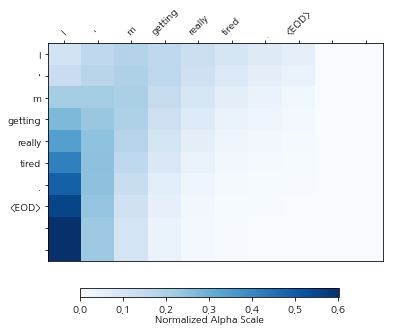

input: I ' m not going to give up . <EOD>
gener: I ' m not going to give up . <EOD>


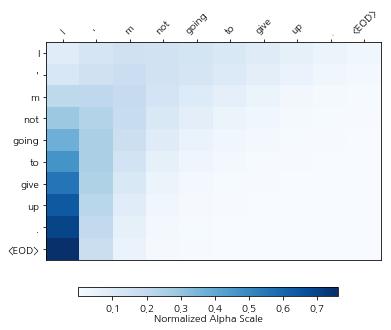

input: It looks like it ' ll rain . <EOD>
gener: It looks like it ' ll rain . <EOD>


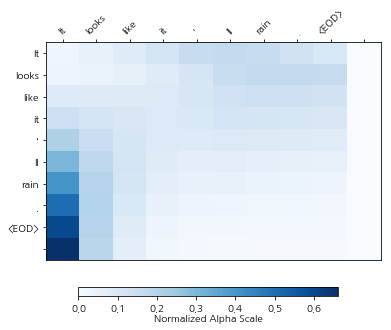

input: Please accept my apology . <EOD>
gener: Please accept my apology . <EOD>


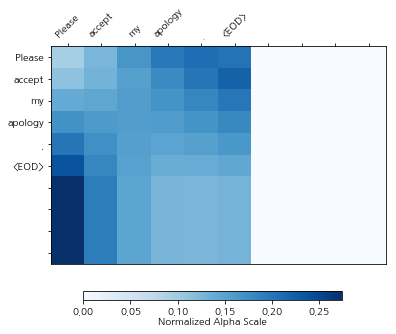

Epoch   0/200 Batch  100/227 - Loss:  4.153
[[[3.24449153e-04 2.35389778e-03 2.03727745e-02 9.63335782e-02
   2.51892000e-01 3.51983964e-01 2.09575355e-01 5.99682890e-02
   6.87687658e-03 3.12741235e-04 6.06231197e-06 8.51311341e-08
   1.22436350e-09]
  [5.04358625e-03 1.34362429e-02 3.91430520e-02 9.13180858e-02
   1.92240551e-01 2.80537724e-01 2.27246717e-01 1.21755891e-01
   2.72995047e-02 1.91103865e-03 6.76372219e-05 0.00000000e+00
   0.00000000e+00]
  [2.60897540e-03 4.08563158e-03 8.19046050e-03 1.88767668e-02
   4.10072058e-02 8.39898810e-02 1.48364782e-01 1.68962017e-01
   1.76386580e-01 1.68973804e-01 1.78553939e-01 0.00000000e+00
   0.00000000e+00]
  [1.97680965e-02 2.72969436e-02 4.44458984e-02 6.63102120e-02
   8.62839967e-02 1.09876737e-01 1.33609623e-01 1.59651399e-01
   1.73739433e-01 1.79017708e-01 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[6.51035598e-03 2.00696271e-02 6.36467114e-02 1.31967172e-01
   2.05870107e-01 2.41204470e-01 1.76796004e-01 9.79609266e

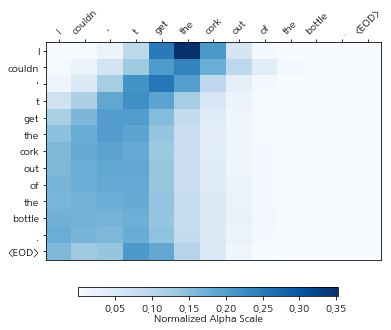

input: I doubt Tom can do that without some help . <EOD>
gener: I doubt Tom can do that without some help . <EOD>


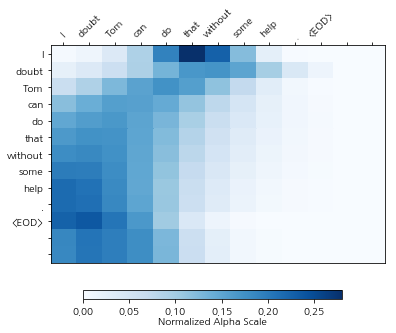

input: Now we have one less thing to worry about . <EOD>
gener: Now we have one less thing to worry about . <EOD>


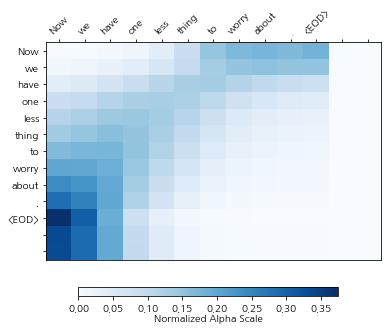

input: She is more beautiful than any other girl . <EOD>
gener: She is more beautiful than any other girl . <EOD>


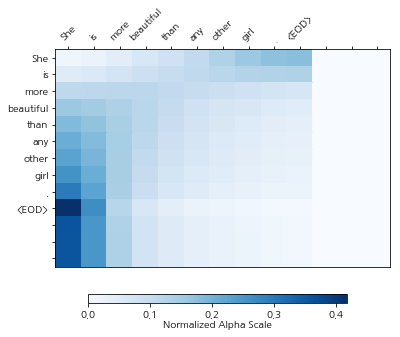

Epoch   0/200 Batch  200/227 - Loss:  4.908
Train perplexity: 120.74002
Epoch   1/200 Batch    0/227 - Loss:  6.525
Epoch   1/200 Batch  100/227 - Loss:  3.445
Epoch   1/200 Batch  200/227 - Loss:  4.574
Train perplexity: 44.35629
Epoch   2/200 Batch    0/227 - Loss:  4.775
Epoch   2/200 Batch  100/227 - Loss:  3.420
Epoch   2/200 Batch  200/227 - Loss:  4.069
Train perplexity: 27.11586
Epoch   3/200 Batch    0/227 - Loss:  3.369
Epoch   3/200 Batch  100/227 - Loss:  2.846
Epoch   3/200 Batch  200/227 - Loss:  3.393
Train perplexity: 17.96088
Epoch   4/200 Batch    0/227 - Loss:  3.033
Epoch   4/200 Batch  100/227 - Loss:  2.854
Epoch   4/200 Batch  200/227 - Loss:  3.257
Train perplexity: 12.04109
Epoch   5/200 Batch    0/227 - Loss:  2.594
Epoch   5/200 Batch  100/227 - Loss:  2.127
Epoch   5/200 Batch  200/227 - Loss:  2.802
Train perplexity: 8.13320
Epoch   6/200 Batch    0/227 - Loss:  1.032
Epoch   6/200 Batch  100/227 - Loss:  2.115
Epoch   6/200 Batch  200/227 - Loss:  2.393
Tr

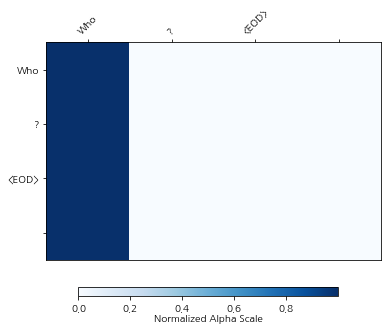

input: Hello ! <EOD>
gener: Hello ! <EOD>


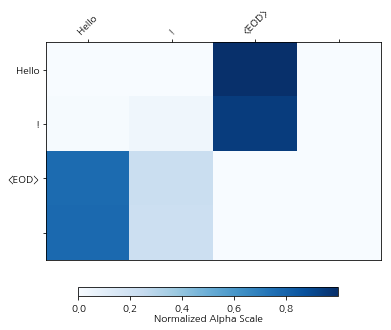

input: No way ! <EOD>
gener: No way ! <EOD>


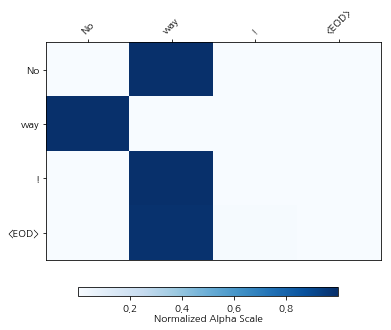

input: No way ! <EOD>
gener: No way ! <EOD>


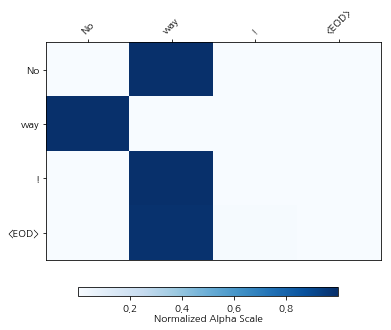

Epoch  20/200 Batch    0/227 - Loss:  0.888
[[[2.43956074e-05 5.31550795e-05 9.99826133e-01 9.62481936e-05
   3.64033560e-11 1.97219530e-15 3.77717402e-17 3.32564450e-19
   0.00000000e+00 0.00000000e+00]
  [3.46030400e-04 2.90512922e-04 2.32897754e-08 7.43422243e-06
   9.99339521e-01 1.64445082e-05 1.36753456e-13 8.40673831e-18
   4.61970396e-21 1.26491865e-22]
  [4.01109474e-18 4.36943538e-14 5.83537940e-07 8.55192840e-01
   1.44806519e-01 1.86901628e-09 5.89312428e-21 8.09427911e-29
   4.74451905e-35 0.00000000e+00]
  [2.52713505e-07 2.32022197e-04 5.51504135e-01 4.48243350e-01
   2.02959181e-05 1.72962367e-10 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[9.99384880e-01 6.15130004e-04 1.26049052e-12 1.84026014e-17
   9.73777903e-19 2.06561164e-19 1.45509794e-19 5.83575922e-19
   0.00000000e+00 0.00000000e+00]
  [9.99204218e-01 7.95794709e-04 9.69552021e-13 4.21468705e-18
   2.52540671e-19 3.15403655e-22 7.24759368e-20 2.07469905e-18
   7.21906241e-20 4.35147667

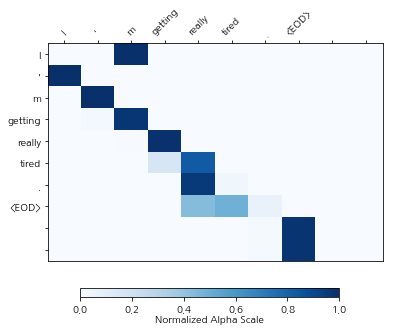

input: I ' m not going to give up . <EOD>
gener: I ' m not going to give up . <EOD>


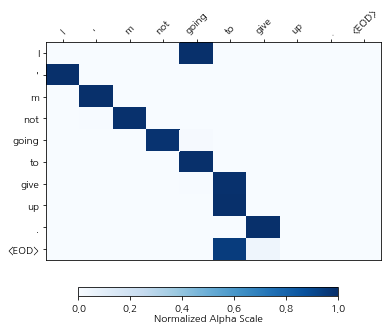

input: It looks like it ' ll rain . <EOD>
gener: It looks like it ' ll rain . <EOD>


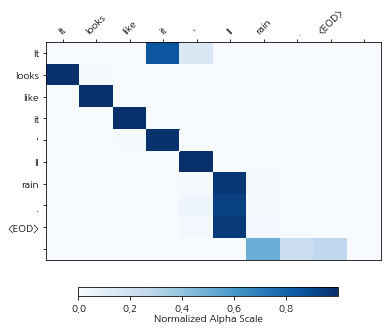

input: Please accept my apology . <EOD>
gener: Please accept my apology . <EOD>


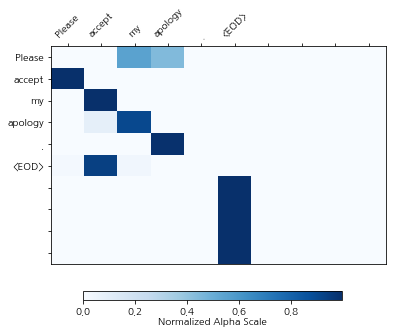

Epoch  20/200 Batch  100/227 - Loss:  0.346
[[[1.07307886e-26 5.99667100e-26 9.31044955e-13 1.00000000e+00
   2.96620648e-08 5.36628091e-20 1.33994074e-30 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [8.82305086e-01 5.99092482e-06 2.63954888e-07 1.17387727e-01
   3.00920743e-04 1.62416774e-10 2.59767954e-11 8.44516002e-17
   3.65293785e-16 1.09662669e-16 1.65933155e-18 0.00000000e+00
   0.00000000e+00]
  [1.68033062e-30 4.06471557e-17 9.95661676e-01 4.33836784e-03
   1.21893346e-15 1.20885739e-22 1.10174508e-28 1.46794338e-38
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [5.97908446e-25 2.57908018e-12 9.99999762e-01 2.40276307e-07
   5.00198474e-18 2.17185930e-25 1.88910183e-28 3.32820046e-35
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[2.40586349e-04 2.08715703e-02 9.78877604e-01 1.02325812e-05
   3.17750654e-13 6.84671025e-17 6.47991190e-17 5.23674313e

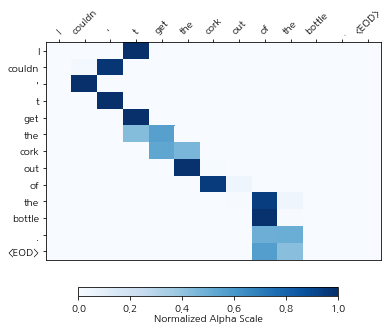

input: I doubt Tom can do that without some help . <EOD>
gener: I doubt Tom can do that without some help . <EOD>


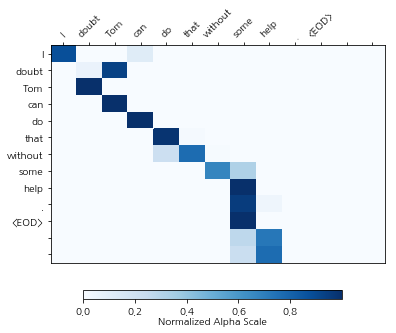

input: Now we have one less thing to worry about . <EOD>
gener: Now we have one less thing to worry about . <EOD>


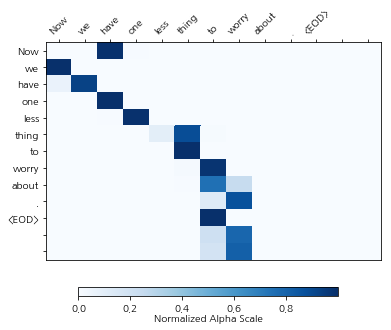

input: She is more beautiful than any other girl . <EOD>
gener: She is more beautiful than any other girl . <EOD>


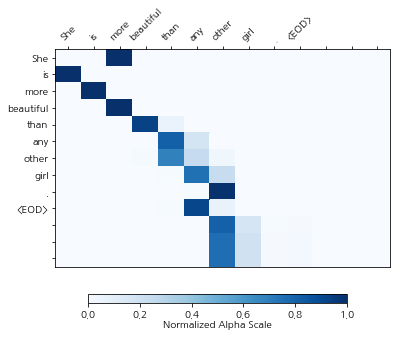

Epoch  20/200 Batch  200/227 - Loss:  0.481
Train perplexity: 1.28679
Epoch  21/200 Batch    0/227 - Loss:  3.124
Epoch  21/200 Batch  100/227 - Loss:  0.024
Epoch  21/200 Batch  200/227 - Loss:  0.336
Train perplexity: 1.22352
Epoch  22/200 Batch    0/227 - Loss:  0.024
Epoch  22/200 Batch  100/227 - Loss:  0.174
Epoch  22/200 Batch  200/227 - Loss:  0.790
Train perplexity: 1.19117
Epoch  23/200 Batch    0/227 - Loss:  0.011
Epoch  23/200 Batch  100/227 - Loss:  0.094
Epoch  23/200 Batch  200/227 - Loss:  0.203
Train perplexity: 1.12559
Epoch  24/200 Batch    0/227 - Loss:  0.019
Epoch  24/200 Batch  100/227 - Loss:  0.039
Epoch  24/200 Batch  200/227 - Loss:  0.092
Train perplexity: 1.12603
Epoch  25/200 Batch    0/227 - Loss:  0.010
Epoch  25/200 Batch  100/227 - Loss:  0.606
Epoch  25/200 Batch  200/227 - Loss:  0.657
Train perplexity: 1.10878
Epoch  26/200 Batch    0/227 - Loss:  0.111
Epoch  26/200 Batch  100/227 - Loss:  0.039
Epoch  26/200 Batch  200/227 - Loss:  0.262
Train pe

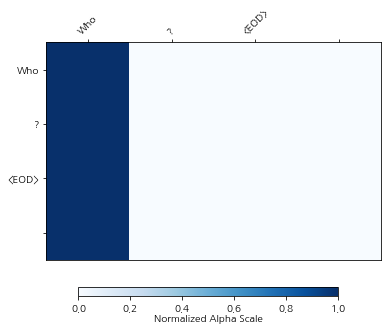

input: Hello ! <EOD>
gener: Hello ! <EOD>


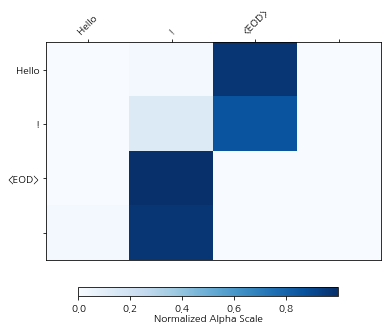

input: No way ! <EOD>
gener: No way ! <EOD>


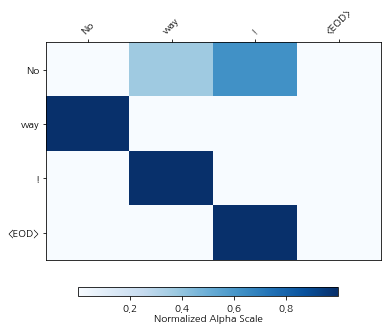

input: No way ! <EOD>
gener: No way ! <EOD>


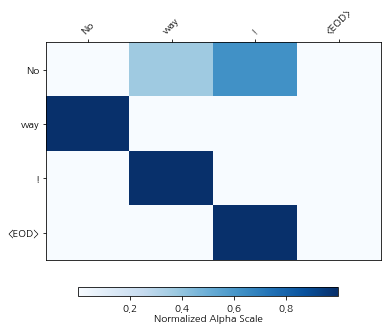

Epoch  40/200 Batch    0/227 - Loss:  0.000
[[[9.93235528e-01 5.50788310e-13 4.46926919e-04 6.31750515e-03
   1.01804272e-08 2.91807689e-09 8.14595651e-15 2.33487367e-20
   0.00000000e+00 0.00000000e+00]
  [6.70199483e-07 8.98350174e-17 1.02489467e-11 2.98467989e-04
   9.99700785e-01 1.11760222e-07 6.69009584e-17 2.82891601e-20
   4.34925724e-19 8.56618024e-22]
  [1.61146446e-28 3.84760695e-28 1.17154552e-18 2.25073066e-07
   9.99771297e-01 2.28494857e-04 2.24715565e-16 5.68633867e-25
   7.54691664e-34 0.00000000e+00]
  [2.57926065e-17 9.42672047e-13 2.80225463e-03 9.97186601e-01
   1.11496065e-05 5.87591607e-12 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[9.99992013e-01 7.99976351e-06 1.51755486e-19 1.07617810e-25
   4.50473971e-23 4.83515567e-20 3.15989426e-16 4.56386095e-15
   0.00000000e+00 0.00000000e+00]
  [9.99997020e-01 3.01660862e-06 1.19547147e-14 1.54267977e-17
   2.00355519e-17 4.16987382e-19 2.62111940e-14 4.18316033e-12
   1.13005429e-15 1.96844337

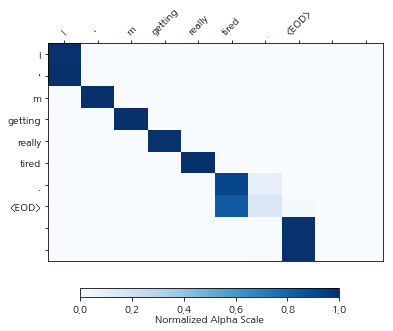

input: I ' m not going to give up . <EOD>
gener: I ' m not going to give up . <EOD>


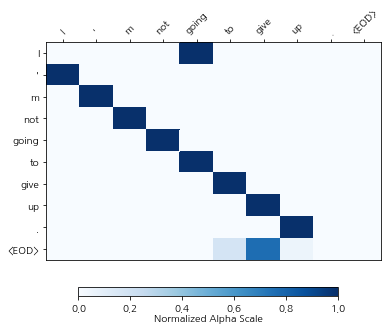

input: It looks like it ' ll rain . <EOD>
gener: It looks like it ' ll rain . <EOD>


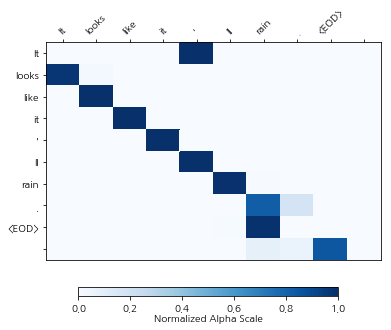

input: Please accept my apology . <EOD>
gener: Please accept my apology . <EOD>


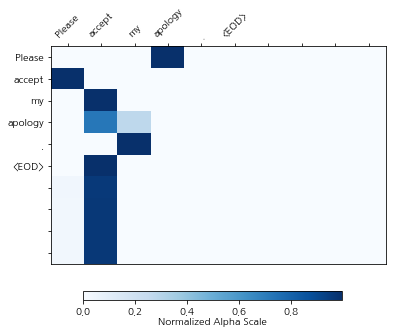

Epoch  40/200 Batch  100/227 - Loss:  0.070
[[[5.51572839e-26 1.11470476e-33 3.50050795e-24 9.34507549e-01
   6.54924437e-02 9.63995386e-16 9.59196312e-26 2.62648461e-31
   1.91844495e-36 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [9.57023349e-09 4.69679145e-34 1.20206987e-26 9.97986913e-01
   2.01303116e-03 4.67514309e-12 3.06063486e-12 3.80016361e-22
   1.50774989e-27 1.87582495e-26 2.06560820e-30 0.00000000e+00
   0.00000000e+00]
  [2.64594698e-32 1.25807451e-25 3.63765268e-10 1.00000000e+00
   2.82685347e-10 9.18156990e-21 3.62532990e-29 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [4.49419412e-28 3.97985112e-13 3.37517049e-05 9.99966264e-01
   8.30583213e-10 1.52233827e-21 1.11534497e-34 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[1.74035504e-03 9.98049855e-01 2.09241596e-04 5.69303722e-07
   1.66326997e-09 9.70946989e-10 5.13669596e-09 1.54773805e

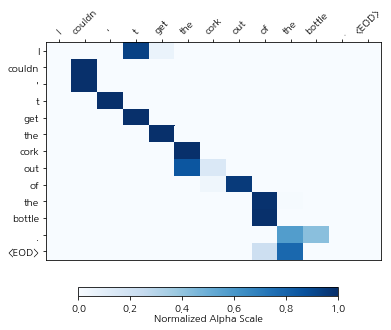

input: I doubt Tom can do that without some help . <EOD>
gener: I doubt Tom can do that without some help . <EOD>


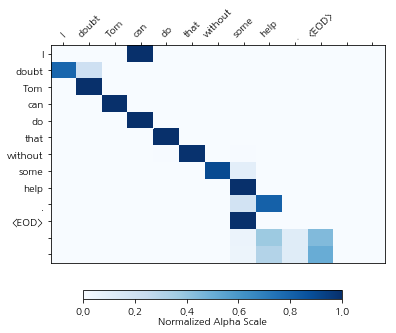

input: Now we have one less thing to worry about . <EOD>
gener: Now we have one less thing to worry about . <EOD>


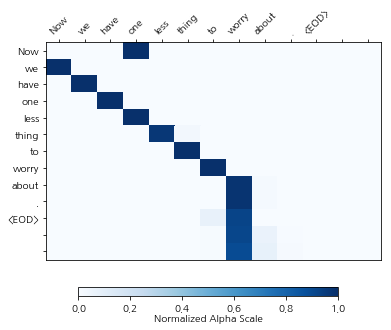

input: She is more beautiful than any other girl . <EOD>
gener: She is more beautiful than any other girl . <EOD>


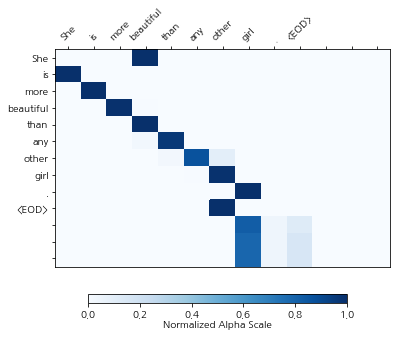

Epoch  40/200 Batch  200/227 - Loss:  0.032
Train perplexity: 1.06086
Epoch  41/200 Batch    0/227 - Loss:  0.000
Epoch  41/200 Batch  100/227 - Loss:  0.026
Epoch  41/200 Batch  200/227 - Loss:  0.095
Train perplexity: 1.06031
Epoch  42/200 Batch    0/227 - Loss:  0.000
Epoch  42/200 Batch  100/227 - Loss:  0.305
Epoch  42/200 Batch  200/227 - Loss:  0.010
Train perplexity: 1.06244
Epoch  43/200 Batch    0/227 - Loss:  0.000
Epoch  43/200 Batch  100/227 - Loss:  0.012
Epoch  43/200 Batch  200/227 - Loss:  0.016
Train perplexity: 1.05430
Epoch  44/200 Batch    0/227 - Loss:  0.000
Epoch  44/200 Batch  100/227 - Loss:  0.003
Epoch  44/200 Batch  200/227 - Loss:  0.104
Train perplexity: 1.07448
Epoch  45/200 Batch    0/227 - Loss:  0.000
Epoch  45/200 Batch  100/227 - Loss:  0.203
Epoch  45/200 Batch  200/227 - Loss:  0.325
Train perplexity: 1.13944
Epoch  46/200 Batch    0/227 - Loss:  0.000
Epoch  46/200 Batch  100/227 - Loss:  0.299
Epoch  46/200 Batch  200/227 - Loss:  0.418
Train pe

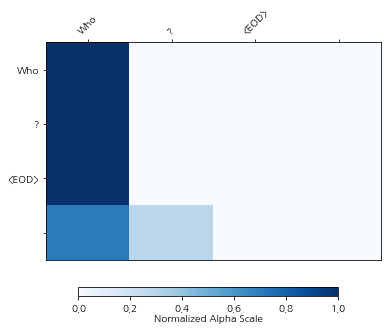

input: Hello ! <EOD>
gener: Hello ! <EOD>


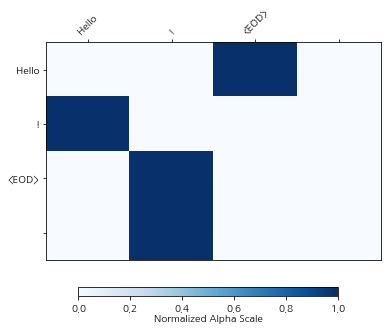

input: No way ! <EOD>
gener: No way ! <EOD>


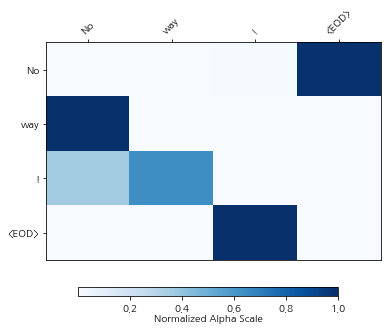

input: No way ! <EOD>
gener: No way ! <EOD>


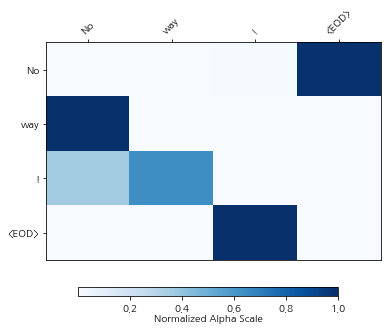

Epoch  60/200 Batch    0/227 - Loss:  0.591
[[[4.90630902e-02 1.65376773e-12 8.92806709e-01 5.81302010e-02
   6.04199983e-16 1.06897504e-20 1.93051860e-33 2.46000048e-36
   0.00000000e+00 0.00000000e+00]
  [1.38581458e-19 4.61239524e-23 1.40472092e-10 1.00000000e+00
   2.21633975e-10 5.91651674e-23 7.65739577e-36 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.34377078e-26 1.56794781e-21 1.78219438e-15 1.64400153e-05
   9.99983549e-01 1.99017441e-10 1.19779545e-24 4.85311843e-33
   1.37342958e-34 0.00000000e+00]
  [4.54416872e-20 4.05047513e-15 1.00000000e+00 1.81687582e-11
   1.52734318e-24 3.07370414e-29 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[9.94567037e-01 5.43299504e-03 8.29336464e-14 2.64025815e-18
   1.21305452e-15 1.63354099e-13 5.47324264e-14 5.29253074e-13
   0.00000000e+00 0.00000000e+00]
  [9.71074760e-01 2.89252903e-02 1.04214519e-11 4.25183779e-16
   1.64173263e-16 8.19596349e-19 1.90569023e-19 3.33371261e-19
   1.68632697e-19 1.68048400

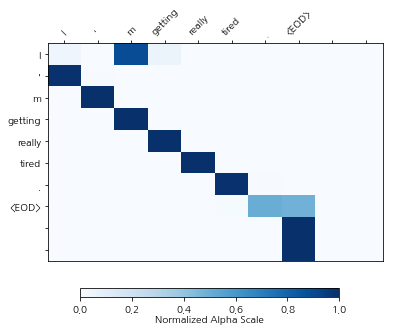

input: I ' m not going to give up . <EOD>
gener: I ' m not going to give up . <EOD>


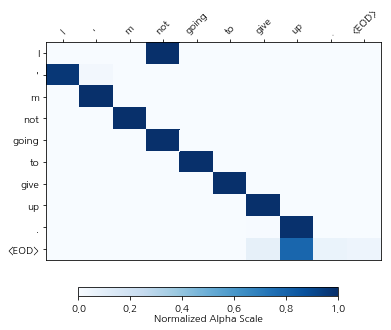

input: It looks like it ' ll rain . <EOD>
gener: It looks like it ' ll rain . <EOD>


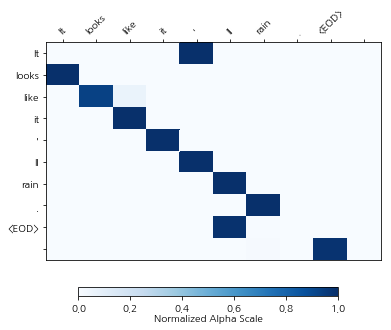

input: Please accept my apology . <EOD>
gener: Please accept my apology . <EOD>


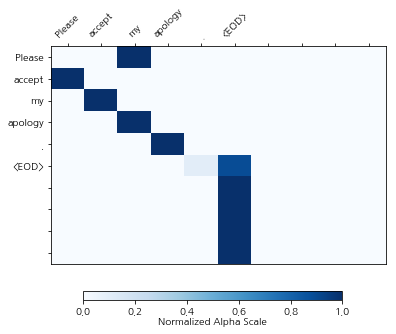

Epoch  60/200 Batch  100/227 - Loss:  0.018
[[[3.92451989e-24 4.04602847e-37 5.33235262e-25 1.00000000e+00
   2.34286688e-08 3.57597843e-22 2.12732482e-27 2.46316675e-29
   6.14835150e-32 5.26507204e-37 0.00000000e+00 5.67334584e-37
   3.94013918e-37]
  [2.55961362e-02 1.95784387e-18 7.55066841e-18 9.74401832e-01
   1.95463940e-06 2.12273754e-09 1.30439215e-10 5.57430223e-15
   1.33518571e-16 3.29679192e-19 1.19481070e-21 0.00000000e+00
   0.00000000e+00]
  [2.56458147e-19 3.88462777e-15 3.22756350e-05 9.99967694e-01
   5.26548227e-08 3.06044556e-12 1.60545498e-20 7.03231471e-26
   1.40804245e-28 2.48980841e-32 8.15689166e-31 0.00000000e+00
   0.00000000e+00]
  [9.06358089e-25 5.12955720e-11 1.00000000e+00 1.60498297e-13
   1.90983266e-28 4.62043703e-33 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[3.65098923e-01 6.34901106e-01 1.76731421e-10 8.63650406e-13
   1.36304341e-18 6.68677401e-19 6.26021603e-17 7.06501268e

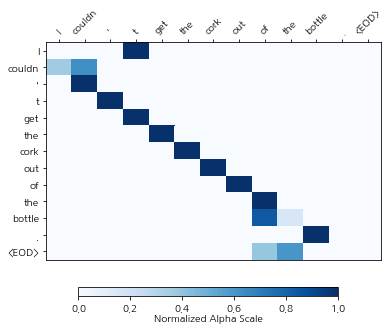

input: I doubt Tom can do that without some help . <EOD>
gener: I doubt Tom can do that without some help . <EOD>


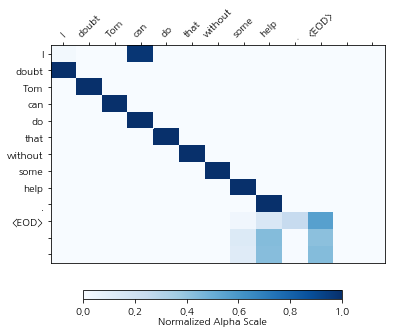

input: Now we have one less thing to worry about . <EOD>
gener: Now we have one less thing to worry about . <EOD>


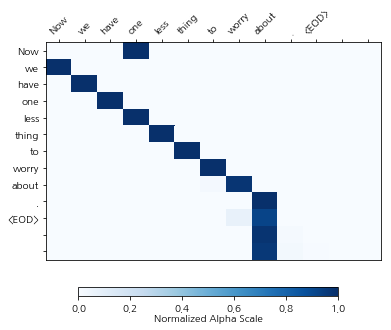

input: She is more beautiful than any other girl . <EOD>
gener: She is more beautiful than any other girl . <EOD>


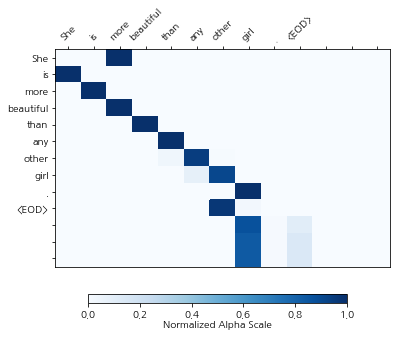

Epoch  60/200 Batch  200/227 - Loss:  0.020
Train perplexity: 1.05977
Epoch  61/200 Batch    0/227 - Loss:  2.525
Epoch  61/200 Batch  100/227 - Loss:  0.002
Epoch  61/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.09716
Epoch  62/200 Batch    0/227 - Loss:  1.640
Epoch  62/200 Batch  100/227 - Loss:  0.001
Epoch  62/200 Batch  200/227 - Loss:  0.003
Train perplexity: 1.07662
Epoch  63/200 Batch    0/227 - Loss:  5.017
Epoch  63/200 Batch  100/227 - Loss:  0.021
Epoch  63/200 Batch  200/227 - Loss:  0.284
Train perplexity: 1.21284
Epoch  64/200 Batch    0/227 - Loss:  0.447
Epoch  64/200 Batch  100/227 - Loss:  0.068
Epoch  64/200 Batch  200/227 - Loss:  0.097
Train perplexity: 1.16234
Epoch  65/200 Batch    0/227 - Loss:  0.018
Epoch  65/200 Batch  100/227 - Loss:  0.471
Epoch  65/200 Batch  200/227 - Loss:  0.340
Train perplexity: 1.11093
Epoch  66/200 Batch    0/227 - Loss:  0.000
Epoch  66/200 Batch  100/227 - Loss:  0.040
Epoch  66/200 Batch  200/227 - Loss:  0.021
Train pe

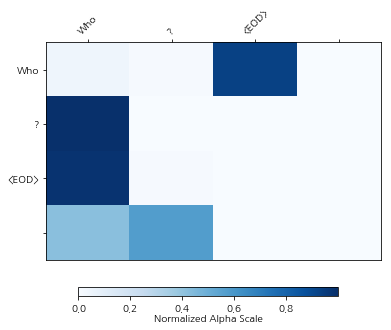

input: Hello ! <EOD>
gener: Hello ! <EOD>


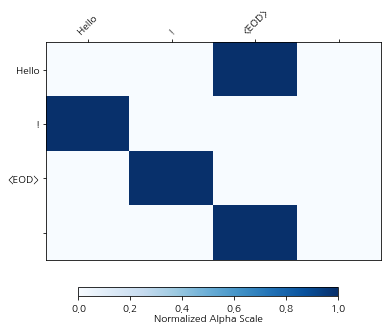

input: No way ! <EOD>
gener: No way ! <EOD>


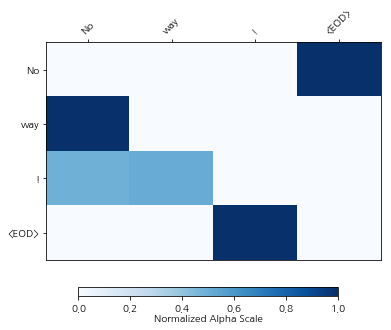

input: No way ! <EOD>
gener: No way ! <EOD>


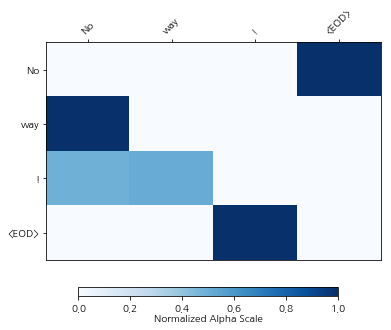

Epoch  80/200 Batch    0/227 - Loss:  0.032
[[[2.18340260e-21 8.50899077e-14 1.00000000e+00 2.64064046e-19
   9.46110662e-36 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.75775618e-21 2.43658683e-15 1.00000000e+00 2.86920601e-22
   1.23129260e-31 1.42179801e-35 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [5.73800008e-33 5.68966307e-23 1.00000000e+00 4.23734849e-18
   1.12331958e-28 1.24774593e-33 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [6.52496517e-14 7.32983167e-08 9.99999881e-01 3.55681012e-10
   1.32871609e-24 5.00199083e-31 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.00000000e+00 9.64647584e-10 3.73062716e-18 1.11150355e-21
   1.32600319e-15 7.52916826e-13 8.45256956e-14 2.28164875e-14
   0.00000000e+00 0.00000000e+00]
  [9.99999881e-01 1.35297810e-07 5.92092070e-11 1.11903082e-11
   7.98126898e-10 1.42319091e-11 2.12071402e-11 1.72799242e-12
   6.55771553e-14 4.00619005

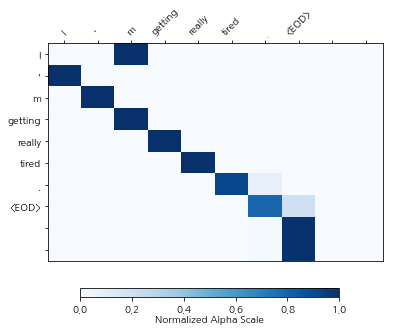

input: I ' m not going to give up . <EOD>
gener: I ' m not going to give up . <EOD>


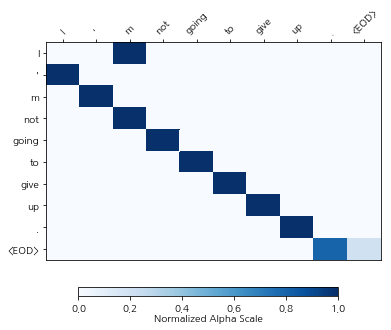

input: It looks like it ' ll rain . <EOD>
gener: It looks like it ' ll rain . <EOD>


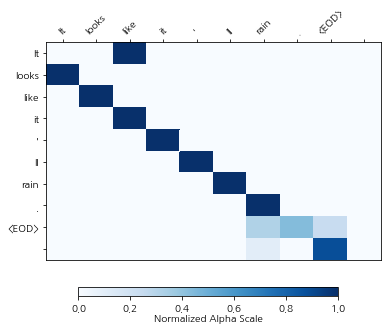

input: Please accept my apology . <EOD>
gener: Please accept my apology . <EOD>


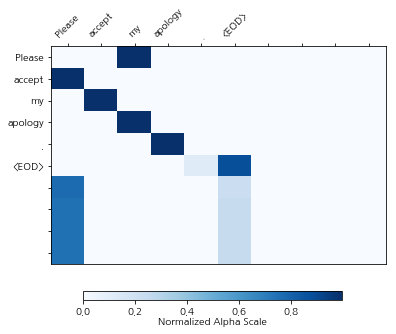

Epoch  80/200 Batch  100/227 - Loss:  0.001
[[[7.99164713e-35 9.75671611e-26 9.99927282e-01 7.27345250e-05
   3.84495980e-23 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [2.29664067e-22 1.36706999e-33 3.65069980e-07 9.99999642e-01
   5.38254059e-11 1.81325422e-22 2.11524377e-26 5.30955602e-25
   2.81100992e-27 1.43787522e-30 7.25341328e-29 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 1.43858926e-37 4.64904951e-23 1.00000000e+00
   6.24607555e-18 2.59337252e-26 2.53360689e-33 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 2.25610188e-33 9.99991894e-01 8.08288314e-06
   1.16292508e-32 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[1.00000000e+00 1.22335996e-11 1.19009558e-16 2.99952527e-14
   8.50079894e-14 5.15979750e-12 5.10670195e-12 2.92529181e

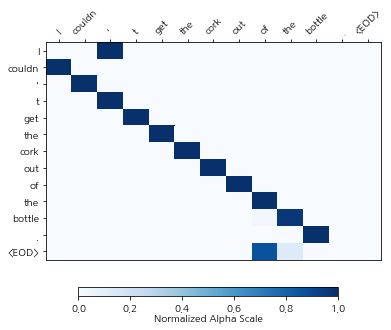

input: I doubt Tom can do that without some help . <EOD>
gener: I doubt Tom can do that without some help . <EOD>


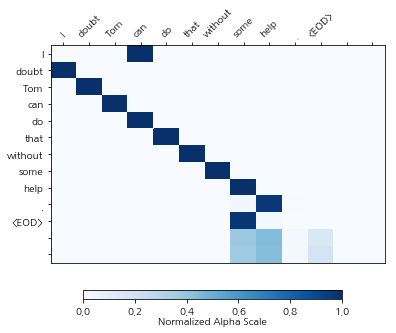

input: Now we have one less thing to worry about . <EOD>
gener: Now we have one less thing to worry about . <EOD>


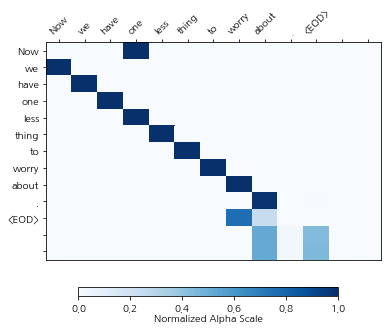

input: She is more beautiful than any other girl . <EOD>
gener: She is more beautiful than any other girl . <EOD>


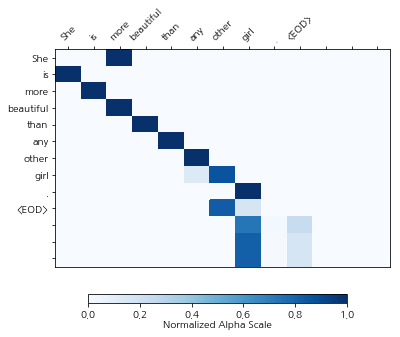

Epoch  80/200 Batch  200/227 - Loss:  0.214
Train perplexity: 1.09285
Epoch  81/200 Batch    0/227 - Loss:  0.495
Epoch  81/200 Batch  100/227 - Loss:  0.005
Epoch  81/200 Batch  200/227 - Loss:  0.017
Train perplexity: 1.06424
Epoch  82/200 Batch    0/227 - Loss:  0.000
Epoch  82/200 Batch  100/227 - Loss:  0.001
Epoch  82/200 Batch  200/227 - Loss:  0.192
Train perplexity: 1.06736
Epoch  83/200 Batch    0/227 - Loss:  0.000
Epoch  83/200 Batch  100/227 - Loss:  0.018
Epoch  83/200 Batch  200/227 - Loss:  0.366
Train perplexity: 1.03276
Epoch  84/200 Batch    0/227 - Loss:  0.026
Epoch  84/200 Batch  100/227 - Loss:  0.020
Epoch  84/200 Batch  200/227 - Loss:  0.005
Train perplexity: 1.10899
Epoch  85/200 Batch    0/227 - Loss:  0.000
Epoch  85/200 Batch  100/227 - Loss:  0.001
Epoch  85/200 Batch  200/227 - Loss:  0.009
Train perplexity: 1.10191
Epoch  86/200 Batch    0/227 - Loss:  0.000
Epoch  86/200 Batch  100/227 - Loss:  0.016
Epoch  86/200 Batch  200/227 - Loss:  0.011
Train pe

KeyboardInterrupt: 

In [26]:
import time
import numpy as np
from __future__ import unicode_literals

display_step = 100
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'

test_step = 20

_att = []

with tf.Session (graph = tf_graph, config=config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    
    flag = False
    for epoch_i in range(0, epochs+1):
        _tcosts = []
        for batch_i, (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                            source_sent_ids,
                                                                                                            batch_size,
                                                                                                             voca_e_to_int[PAD],
                                                                                                             voca_e_to_int[PAD]
                                                                                                            )):
            
            if batch_i % display_step == 0 and epoch_i%test_step==0:
                _, loss, attention = sess.run([train_op, cost, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
                _att = attention
                print(_att)
                

                for ans_i in range(batch_size):
                    ans = targets_batch[ans_i]
                    _ans = ""
                    for v in ans:
                        if v == voca_e_to_int[EOD]:

                            _ans += int_to_voca_e[v]
                            break
                        else:

                            _ans += int_to_voca_e[v]+" "



                    org = sources_batch[ans_i]
                    _org = ""
                    for v in org:
                        if v == voca_e_to_int[EOD]:
                            _org += int_to_voca_e[v]
                            break
                        else:
                            _org += int_to_voca_e[v]+" "

                    print("input: {}".format(_org))
                    print("gener: {}".format(_ans))
                    my_plot(attention[:, ans_i, :], _org.split(), _ans.split())
                #print(_att)                
                
            else:
                _, loss = sess.run([train_op, cost], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
            

            
            _tcosts.append(loss)
            
            #print(batch_i, loss)
            
            if batch_i % display_step == 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}'.format(epoch_i, 
                                                                              epochs,
                                                                              batch_i,
                                                                              len(source_sent_ids)//batch_size,
                                                                              loss))  
               
            #print(sources_batch)
            
        
        print('Train perplexity: {:>6.5f}'.format(np.exp(np.mean(_tcosts))))
        
        '''
        if epoch_i%test_step == 0:
            (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                   target_sent_ids,
                                                                                                   batch_size,
                                                                                                   voca_e_to_int[PAD],
                                                                                                   voca_k_to_int[PAD]))
            answer_logits, attention = sess.run([inference_logits, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                       targets: targets_batch,
                                                        target_sequence_length: target_lengths,source_sequence_length: source_lengths})
        
            for ans_i in range(len(answer_logits)):
                ans = np.transpose(answer_logits[ans_i]).tolist()
                _ans = ""
                for v in ans:
                    if v == voca_k_to_int[EOD]:
                        
                        _ans += int_to_voca_k[v]
                        break
                    else:
                        
                        _ans += int_to_voca_k[v]+" "
                        
                
                
                org = sources_batch[ans_i]
                _org = ""
                for v in org:
                    if v == voca_e_to_int[EOD]:
                        _org += int_to_voca_e[v]
                        break
                    else:
                        _org += int_to_voca_e[v]+" "
                        
                print("input: {}".format(_org))
                print("gener: {}".format(_ans))
                my_plot(attention[:, ans_i, :source_lengths[ans_i]], _org.split(), _ans.split())
        '''
        #break
    run_time = time.time() - start_time
    print('Run Time : %s seconds' %(run_time))

[[[0.33318645 0.33332554 0.33348805 0.        ]
  [0.33338264 0.33328897 0.33332843 0.        ]
  [0.2500437  0.2500591  0.2499899  0.2499073 ]
  [0.2500437  0.2500591  0.2499899  0.2499073 ]]

 [[0.3331917  0.3333375  0.33347085 0.        ]
  [0.3333506  0.33329096 0.3333584  0.        ]
  [0.25000292 0.25004408 0.2500057  0.24994732]
  [0.24999514 0.25004172 0.2500084  0.24995473]]

 [[0.33318326 0.333352   0.33346474 0.        ]
  [0.3333107  0.33329794 0.33339137 0.        ]
  [0.24995339 0.25003475 0.2500191  0.24999279]
  [0.24994995 0.25002196 0.25002217 0.25000596]]

 [[0.33315828 0.33337054 0.3334712  0.        ]
  [0.3332832  0.33330917 0.33340764 0.        ]
  [0.24990155 0.25001785 0.2500325  0.2500481 ]
  [0.24991444 0.25000432 0.25003058 0.25005063]]

 [[0.33316094 0.3333591  0.33348    0.        ]
  [0.33328032 0.33330002 0.33341968 0.        ]
  [0.24985746 0.24999437 0.2500459  0.25010228]
  [0.24987678 0.25000232 0.25004736 0.25007358]]

 [[0.33316094 0.3333591  0.333

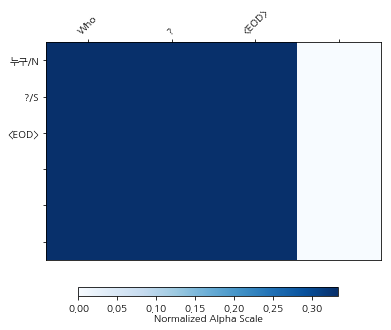

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


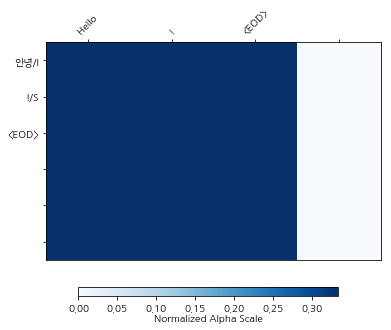

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


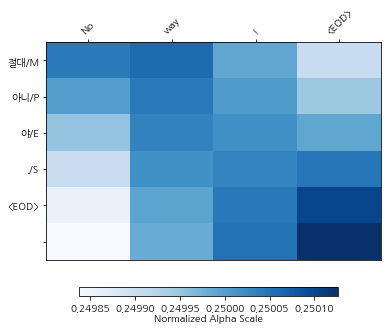

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


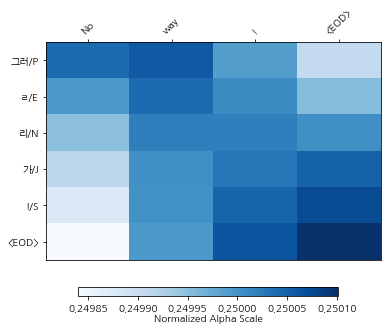

Epoch   0/200 Batch    0/227 - Loss:  7.200
[[[0.3911761  0.24463217 0.14758109 0.08640992 0.05209018 0.03526726
   0.02509598 0.01774729 0.         0.        ]
  [0.36591366 0.24488078 0.15417598 0.0932329  0.05590097 0.03334531
   0.02134548 0.01372405 0.01000357 0.00747725]
  [0.30707553 0.20155841 0.13643484 0.09953913 0.08126599 0.06485525
   0.04832    0.03537127 0.02557962 0.        ]
  [0.38600105 0.25912264 0.14849298 0.09285589 0.06653928 0.04698819
   0.         0.         0.         0.        ]]

 [[0.2680014  0.21414982 0.16085126 0.11558723 0.08575473 0.06757363
   0.05082957 0.03725233 0.         0.        ]
  [0.27909473 0.22066775 0.15964706 0.10596281 0.07246952 0.05167166
   0.03948349 0.03058819 0.02339161 0.01702319]
  [0.19185098 0.15224402 0.1298821  0.11703621 0.10708941 0.09823828
   0.08452455 0.06799207 0.05114234 0.        ]
  [0.2601099  0.21665935 0.17580685 0.14494072 0.11358546 0.08889773
   0.         0.         0.         0.        ]]

 [[0.1367851  0.

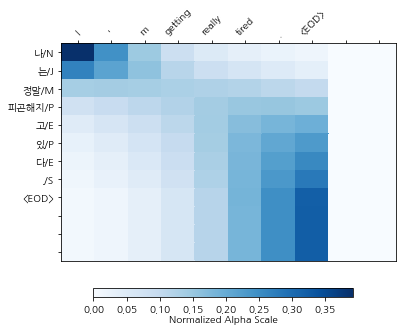

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


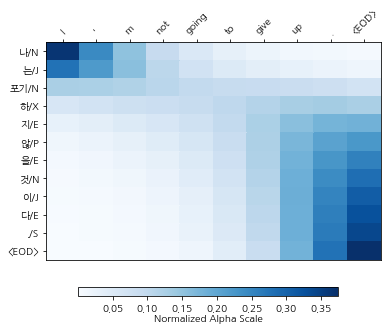

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


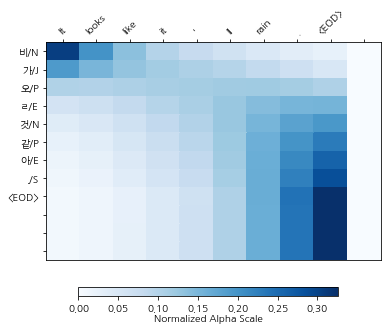

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


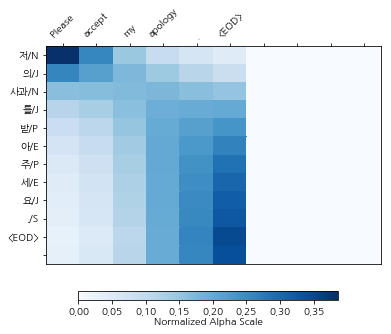

Epoch   0/200 Batch  100/227 - Loss:  4.459
[[[0.18775918 0.16751038 0.14678979 0.11232936 0.08582625 0.06805865
   0.05353198 0.04007899 0.03438203 0.03268449 0.03051949 0.02106851
   0.01946096]
  [0.35332194 0.2764597  0.17544706 0.09324218 0.04910175 0.02676457
   0.01215441 0.00636207 0.00444436 0.00183515 0.00086686 0.
   0.        ]
  [0.05791051 0.05635548 0.05722309 0.06200213 0.07071897 0.07975938
   0.09534513 0.11244801 0.1343923  0.13083242 0.1430126  0.
   0.        ]
  [0.1267334  0.1090045  0.10124939 0.09903117 0.09872206 0.10261439
   0.10390033 0.10390706 0.08026367 0.07457402 0.         0.
   0.        ]]

 [[0.05109555 0.06018969 0.06110663 0.06238707 0.06088111 0.05529237
   0.05297203 0.06024739 0.07862931 0.09714305 0.11102729 0.11887008
   0.13015848]
  [0.02718626 0.03821696 0.04400549 0.07561062 0.08761605 0.10946402
   0.11367661 0.12588878 0.13125004 0.13004981 0.11703535 0.
   0.        ]
  [0.02144853 0.02300085 0.02793362 0.03160802 0.03726418 0.04906051

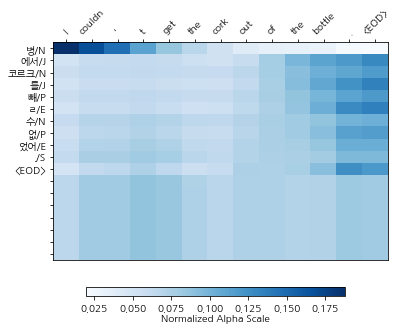

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


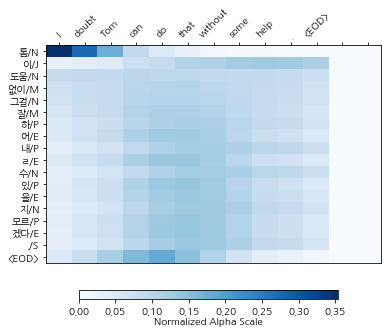

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


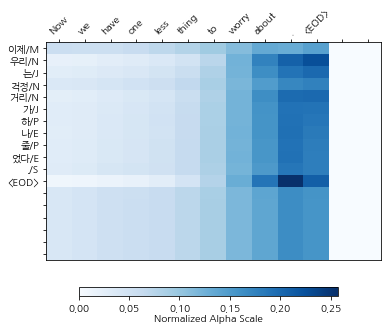

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


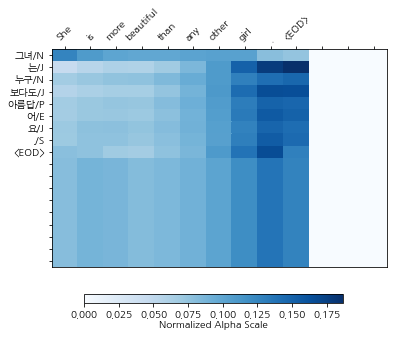

Epoch   0/200 Batch  200/227 - Loss:  4.873
Train perplexity: 142.62169
Epoch   1/200 Batch    0/227 - Loss:  5.423
Epoch   1/200 Batch  100/227 - Loss:  3.642
Epoch   1/200 Batch  200/227 - Loss:  4.359
Train perplexity: 56.80223
Epoch   2/200 Batch    0/227 - Loss:  4.674
Epoch   2/200 Batch  100/227 - Loss:  3.054
Epoch   2/200 Batch  200/227 - Loss:  4.184
Train perplexity: 36.08810
Epoch   3/200 Batch    0/227 - Loss:  4.126
Epoch   3/200 Batch  100/227 - Loss:  2.767
Epoch   3/200 Batch  200/227 - Loss:  3.830
Train perplexity: 23.84365
Epoch   4/200 Batch    0/227 - Loss:  3.612
Epoch   4/200 Batch  100/227 - Loss:  2.402
Epoch   4/200 Batch  200/227 - Loss:  3.505
Train perplexity: 18.05509
Epoch   5/200 Batch    0/227 - Loss:  2.706
Epoch   5/200 Batch  100/227 - Loss:  2.463
Epoch   5/200 Batch  200/227 - Loss:  3.337
Train perplexity: 13.73178
Epoch   6/200 Batch    0/227 - Loss:  2.709
Epoch   6/200 Batch  100/227 - Loss:  2.379
Epoch   6/200 Batch  200/227 - Loss:  2.974
T

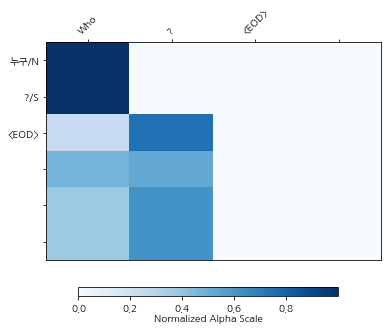

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


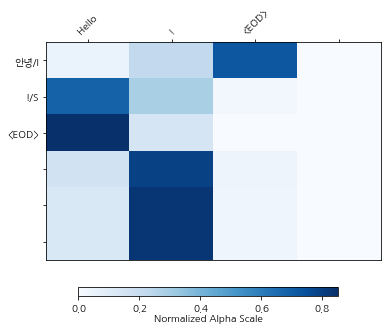

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


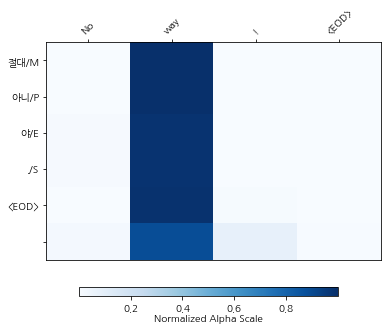

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


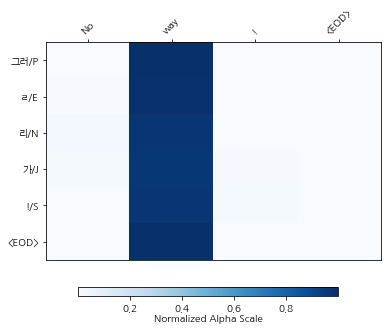

Epoch  20/200 Batch    0/227 - Loss:  0.278
[[[3.94650632e-11 4.08654159e-07 2.32853098e-10 1.60119816e-05
   9.95545983e-01 4.43724496e-03 3.19908906e-07 1.49693236e-09
   0.00000000e+00 0.00000000e+00]
  [1.31259881e-07 1.11311267e-03 2.13692822e-02 1.11306652e-01
   7.23451316e-01 5.65621480e-02 8.61827210e-02 1.46175789e-05
   3.10970893e-09 1.90177540e-09]
  [7.66290352e-02 9.40541923e-02 8.28210354e-01 1.09964260e-03
   6.58597719e-06 1.02398005e-07 1.69798597e-09 1.11927481e-10
   2.68588927e-12 0.00000000e+00]
  [9.75560077e-09 1.34180812e-03 9.36888993e-01 6.17638007e-02
   5.26566191e-06 5.60664191e-08 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.03906127e-05 1.68239621e-05 1.27080586e-08 1.11881678e-03
   9.65950847e-01 3.27484123e-02 1.34108472e-04 6.36812558e-07
   0.00000000e+00 0.00000000e+00]
  [3.46204332e-09 5.65906594e-05 2.93111952e-04 7.93324690e-03
   9.89723325e-01 2.04056458e-04 1.78808556e-03 1.54922066e-06
   2.98542885e-10 2.08644733

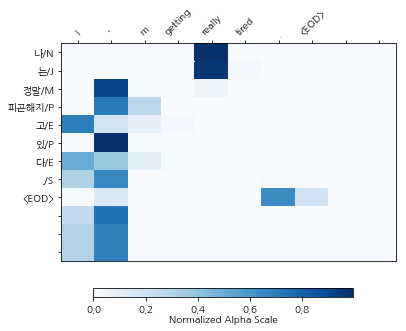

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


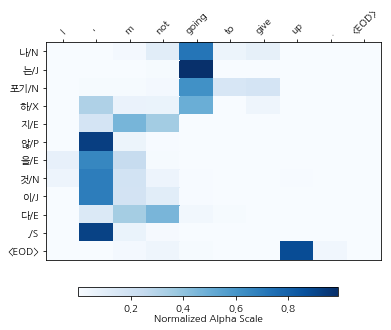

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


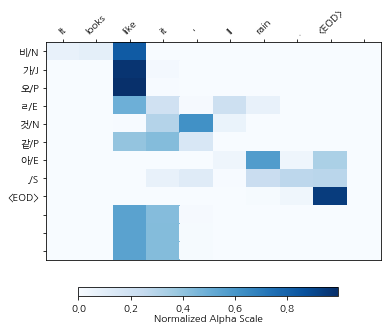

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


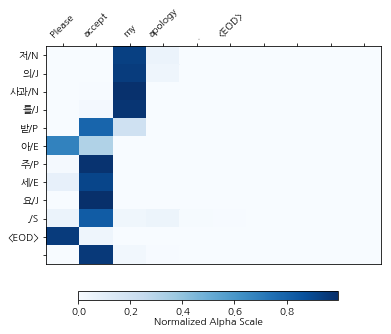

Epoch  20/200 Batch  100/227 - Loss:  0.411
[[[9.99472036e-07 9.89697874e-01 1.02331536e-02 6.80707089e-05
   1.86244868e-08 1.22873142e-10 1.21923457e-10 1.48907597e-09
   2.63442670e-11 1.57900684e-15 4.19298080e-15 3.86486687e-13
   9.68998915e-14]
  [3.81174095e-06 9.99403238e-01 5.90299373e-04 2.64532628e-06
   2.83043189e-09 4.45748283e-09 3.12367775e-12 1.20237709e-13
   2.27108957e-10 1.89296721e-11 6.91660704e-12 0.00000000e+00
   0.00000000e+00]
  [2.40373975e-05 3.59177066e-04 9.29463327e-01 6.87300563e-02
   1.42157963e-03 1.78080586e-06 3.36414317e-12 1.11816719e-12
   2.22843160e-13 3.64772748e-15 1.86942713e-15 0.00000000e+00
   0.00000000e+00]
  [5.56288799e-03 9.64275841e-03 9.77255881e-01 7.53842900e-03
   3.84179231e-08 2.83429197e-10 2.68986179e-12 4.21317000e-14
   7.03074801e-17 1.79691112e-18 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[3.39216015e-08 9.99558747e-01 3.72753741e-04 6.72744354e-05
   6.48093632e-08 1.65812530e-10 8.47976089e-09 1.06707716e

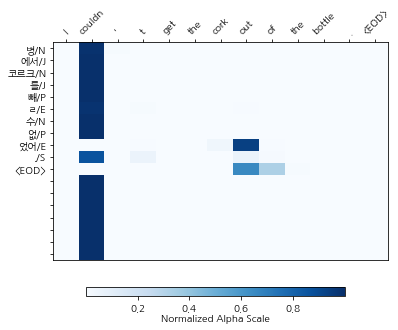

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


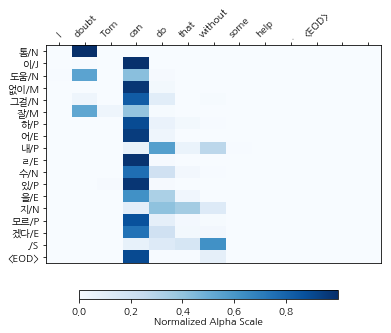

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


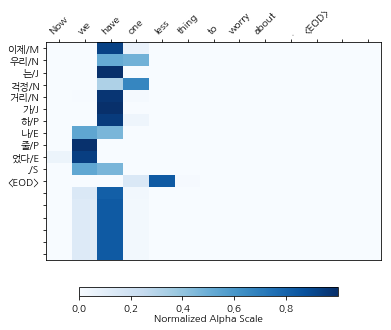

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


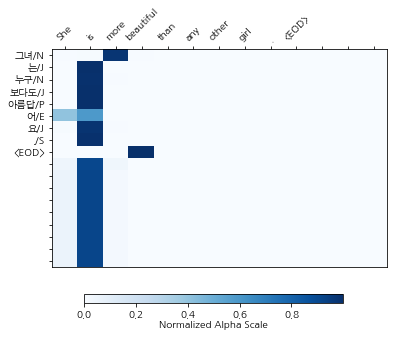

Epoch  20/200 Batch  200/227 - Loss:  0.584
Train perplexity: 1.48506
Epoch  21/200 Batch    0/227 - Loss:  0.695
Epoch  21/200 Batch  100/227 - Loss:  0.361
Epoch  21/200 Batch  200/227 - Loss:  0.353
Train perplexity: 1.45059
Epoch  22/200 Batch    0/227 - Loss:  0.675
Epoch  22/200 Batch  100/227 - Loss:  0.317
Epoch  22/200 Batch  200/227 - Loss:  0.399
Train perplexity: 1.43468
Epoch  23/200 Batch    0/227 - Loss:  0.643
Epoch  23/200 Batch  100/227 - Loss:  0.165
Epoch  23/200 Batch  200/227 - Loss:  0.341
Train perplexity: 1.35526
Epoch  24/200 Batch    0/227 - Loss:  0.465
Epoch  24/200 Batch  100/227 - Loss:  0.262
Epoch  24/200 Batch  200/227 - Loss:  0.190
Train perplexity: 1.32257
Epoch  25/200 Batch    0/227 - Loss:  0.482
Epoch  25/200 Batch  100/227 - Loss:  0.195
Epoch  25/200 Batch  200/227 - Loss:  0.239
Train perplexity: 1.31032
Epoch  26/200 Batch    0/227 - Loss:  0.242
Epoch  26/200 Batch  100/227 - Loss:  0.302
Epoch  26/200 Batch  200/227 - Loss:  0.266
Train pe

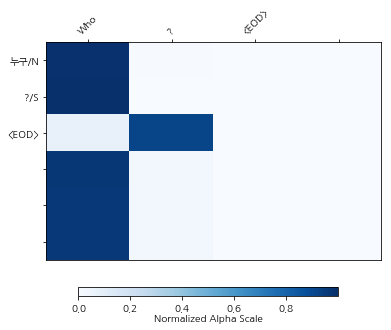

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


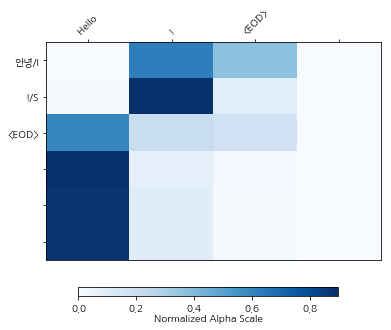

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


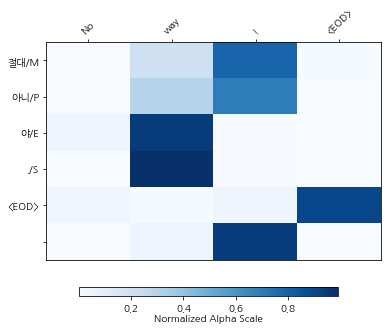

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


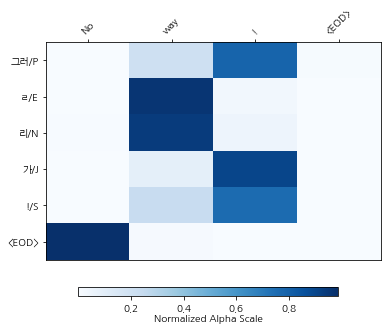

Epoch  40/200 Batch    0/227 - Loss:  0.292
[[[2.84392150e-12 1.26304701e-06 4.28142157e-05 9.98691618e-01
   1.26405281e-03 2.27509958e-07 2.14278161e-12 2.22826654e-13
   0.00000000e+00 0.00000000e+00]
  [8.10348871e-11 3.19794839e-04 1.44545836e-02 9.67323363e-01
   1.78533792e-02 4.74291592e-05 1.49596360e-06 2.03758191e-10
   5.12702470e-14 2.97154201e-14]
  [1.19039448e-11 4.37932613e-04 9.99562085e-01 7.59665486e-09
   1.13715475e-15 2.63913782e-22 7.87998243e-27 1.43427891e-28
   8.14227039e-31 0.00000000e+00]
  [3.06469265e-05 9.81509209e-01 1.80987958e-02 3.61336570e-04
   5.61047960e-14 1.11939581e-18 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.29562939e-16 1.32210204e-12 1.45095091e-09 9.00032103e-01
   9.93299484e-02 6.37880235e-04 4.98793433e-08 8.74856898e-09
   0.00000000e+00 0.00000000e+00]
  [5.81764255e-11 7.71113537e-06 7.56971771e-04 2.27206110e-04
   5.39585575e-02 4.61940952e-02 8.97975624e-01 8.79817992e-04
   1.57847175e-08 3.23681881

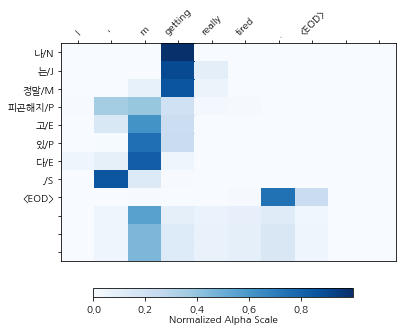

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


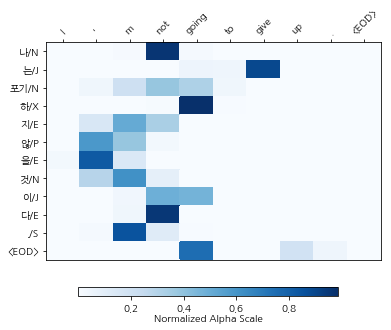

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


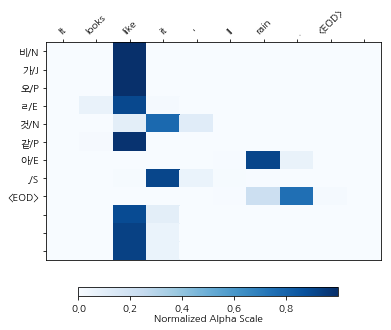

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


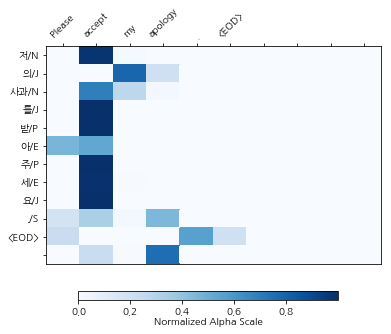

Epoch  40/200 Batch  100/227 - Loss:  0.081
[[[4.29412195e-09 9.04739678e-01 7.50235394e-02 2.02345308e-02
   2.29546708e-06 8.57423821e-09 3.27354921e-10 2.53972121e-10
   1.88513896e-12 1.43446327e-16 8.36223682e-17 7.04951090e-15
   1.92066872e-14]
  [1.64336378e-09 1.56372218e-04 9.99361217e-01 4.82402771e-04
   7.86126442e-10 4.46477272e-10 7.80323018e-13 8.16595030e-16
   1.19935977e-14 3.37010799e-15 3.65050829e-15 0.00000000e+00
   0.00000000e+00]
  [6.04627839e-14 1.68535098e-05 9.99975204e-01 7.94291009e-06
   3.76984777e-10 3.65046196e-14 2.02728556e-22 1.69107128e-22
   6.63998739e-23 4.03808924e-25 1.44982369e-24 0.00000000e+00
   0.00000000e+00]
  [1.00000000e+00 2.65419828e-08 9.21612352e-12 6.45412424e-15
   3.12255553e-17 7.64544098e-18 6.70095201e-20 8.53862640e-22
   4.00011145e-22 7.42910262e-23 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[7.72945441e-07 6.83940768e-01 2.19445303e-01 9.66075584e-02
   4.21546656e-06 9.46770573e-09 4.68323762e-08 1.20758557e

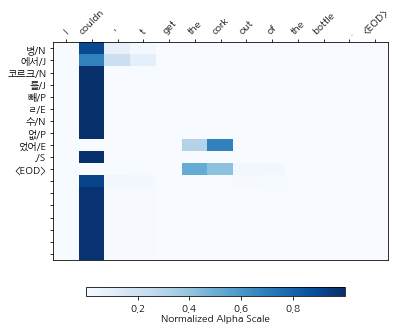

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


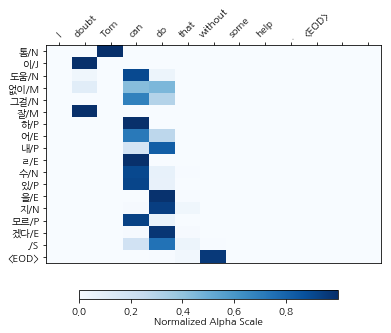

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


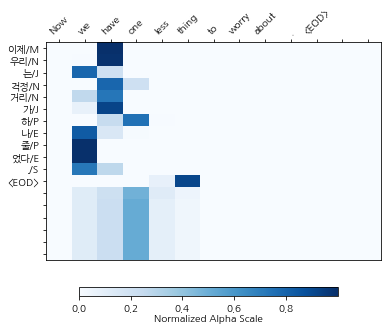

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


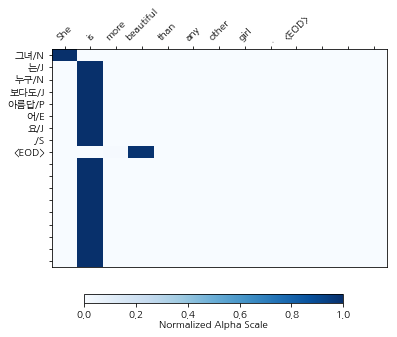

Epoch  40/200 Batch  200/227 - Loss:  0.037
Train perplexity: 1.18235
Epoch  41/200 Batch    0/227 - Loss:  0.303
Epoch  41/200 Batch  100/227 - Loss:  0.090
Epoch  41/200 Batch  200/227 - Loss:  0.390
Train perplexity: 1.21503
Epoch  42/200 Batch    0/227 - Loss:  0.200
Epoch  42/200 Batch  100/227 - Loss:  0.147
Epoch  42/200 Batch  200/227 - Loss:  0.116
Train perplexity: 1.28735
Epoch  43/200 Batch    0/227 - Loss:  0.174
Epoch  43/200 Batch  100/227 - Loss:  0.274
Epoch  43/200 Batch  200/227 - Loss:  0.137
Train perplexity: 1.28986
Epoch  44/200 Batch    0/227 - Loss:  0.585
Epoch  44/200 Batch  100/227 - Loss:  0.080
Epoch  44/200 Batch  200/227 - Loss:  0.099
Train perplexity: 1.30457
Epoch  45/200 Batch    0/227 - Loss:  0.451
Epoch  45/200 Batch  100/227 - Loss:  0.170
Epoch  45/200 Batch  200/227 - Loss:  0.141
Train perplexity: 1.31086
Epoch  46/200 Batch    0/227 - Loss:  0.490
Epoch  46/200 Batch  100/227 - Loss:  0.122
Epoch  46/200 Batch  200/227 - Loss:  0.315
Train pe

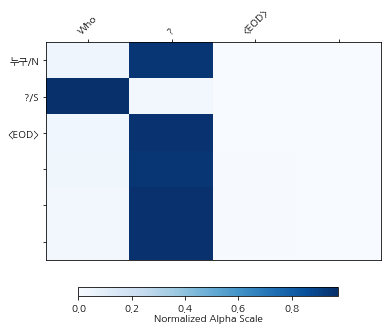

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


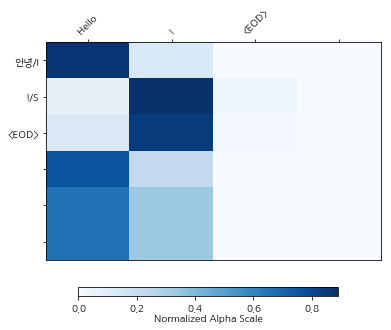

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


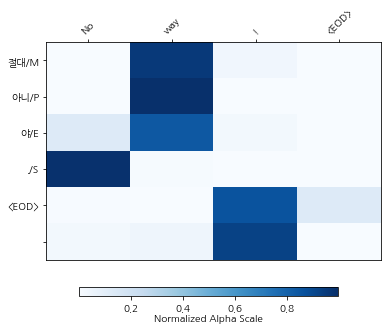

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


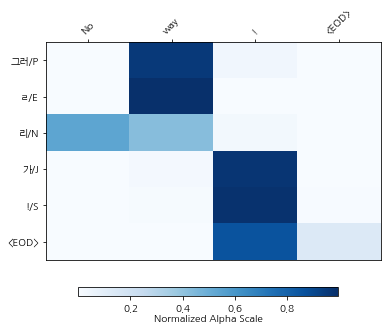

Epoch  60/200 Batch    0/227 - Loss:  0.395
[[[3.46740425e-14 1.21654521e-05 4.41695913e-04 9.98775661e-01
   7.70505110e-04 1.10162421e-08 2.31658497e-13 1.01286514e-14
   0.00000000e+00 0.00000000e+00]
  [1.26718247e-10 1.41293416e-03 4.81287464e-02 8.98436069e-01
   5.20216189e-02 6.18712022e-07 2.84156521e-08 2.20523998e-11
   1.72988675e-14 5.41416514e-14]
  [6.49301457e-09 7.27566242e-01 2.72433788e-01 2.69019540e-09
   2.55618140e-12 1.16362803e-15 4.81421888e-18 2.14903811e-19
   1.03712377e-19 0.00000000e+00]
  [6.96676450e-09 9.97733831e-01 2.25565257e-03 1.05072741e-05
   3.57812890e-12 1.03090164e-13 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.18669419e-12 7.66792352e-10 6.37383835e-08 9.74344134e-01
   2.52548885e-02 4.00346762e-04 5.01056377e-07 4.64161047e-08
   0.00000000e+00 0.00000000e+00]
  [2.34272289e-11 1.23039229e-07 1.34225886e-07 5.75682257e-09
   9.99999285e-01 4.88460159e-07 5.57721924e-11 5.40688397e-11
   4.53458831e-13 1.28007902

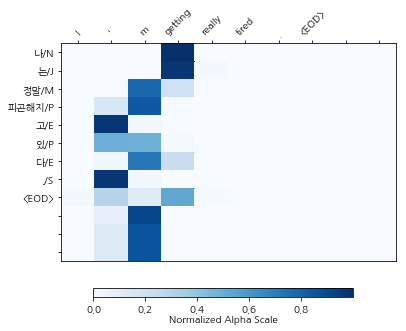

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


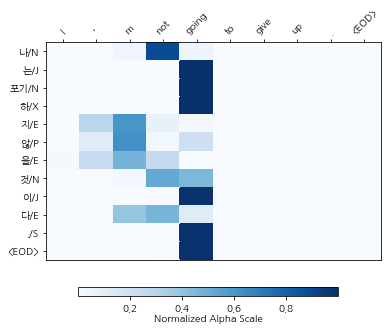

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


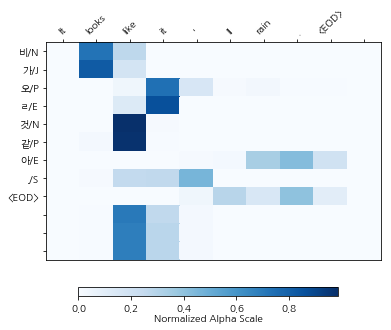

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


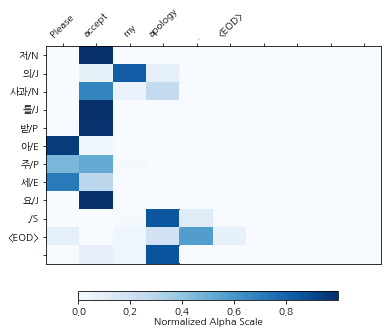

Epoch  60/200 Batch  100/227 - Loss:  0.093
[[[1.13148024e-08 7.07175732e-01 6.19664118e-02 2.30850533e-01
   7.31483578e-06 1.20706178e-09 1.59766034e-10 1.82966656e-10
   1.58024843e-11 4.53623921e-14 3.30523945e-14 1.34912672e-14
   2.21095081e-14]
  [1.16666510e-10 1.13310239e-06 9.99998689e-01 9.76263976e-08
   8.65880891e-12 3.99420866e-13 1.09895365e-16 1.28457609e-17
   7.33024629e-18 2.23434327e-20 1.24985335e-20 0.00000000e+00
   0.00000000e+00]
  [3.72069212e-06 1.72032742e-03 9.66942132e-01 2.55155144e-03
   2.87490077e-02 3.31985575e-05 1.86636129e-09 3.08263282e-08
   4.23784424e-10 5.60286817e-11 5.24336720e-11 0.00000000e+00
   0.00000000e+00]
  [9.99761164e-01 2.38774010e-04 4.71208050e-09 4.72652528e-10
   1.38191447e-09 1.07426723e-09 6.58500738e-08 2.19327800e-09
   3.02119788e-11 1.65149994e-11 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[1.76501228e-04 2.84614433e-02 1.04133256e-01 8.66344154e-01
   8.72448087e-04 6.88336786e-06 3.16022988e-06 1.67514224e

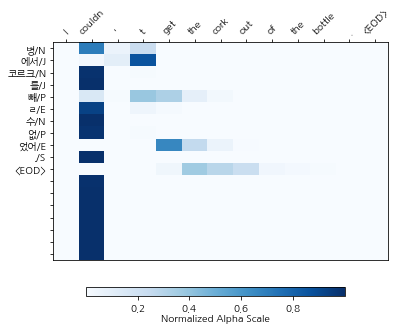

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


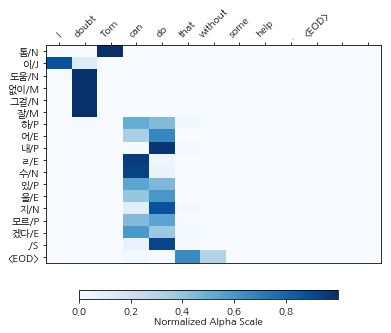

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


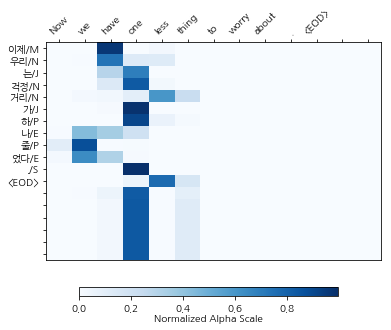

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


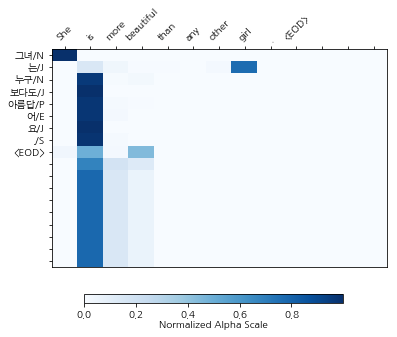

Epoch  60/200 Batch  200/227 - Loss:  0.020
Train perplexity: 1.15307
Epoch  61/200 Batch    0/227 - Loss:  0.163
Epoch  61/200 Batch  100/227 - Loss:  0.065
Epoch  61/200 Batch  200/227 - Loss:  0.026
Train perplexity: 1.12532
Epoch  62/200 Batch    0/227 - Loss:  0.306
Epoch  62/200 Batch  100/227 - Loss:  0.044
Epoch  62/200 Batch  200/227 - Loss:  0.025
Train perplexity: 1.11740
Epoch  63/200 Batch    0/227 - Loss:  0.225
Epoch  63/200 Batch  100/227 - Loss:  0.009
Epoch  63/200 Batch  200/227 - Loss:  0.022
Train perplexity: 1.10120
Epoch  64/200 Batch    0/227 - Loss:  0.182
Epoch  64/200 Batch  100/227 - Loss:  0.032
Epoch  64/200 Batch  200/227 - Loss:  0.039
Train perplexity: 1.11713
Epoch  65/200 Batch    0/227 - Loss:  0.351
Epoch  65/200 Batch  100/227 - Loss:  0.022
Epoch  65/200 Batch  200/227 - Loss:  0.198
Train perplexity: 1.19051
Epoch  66/200 Batch    0/227 - Loss:  0.288
Epoch  66/200 Batch  100/227 - Loss:  0.063
Epoch  66/200 Batch  200/227 - Loss:  0.044
Train pe

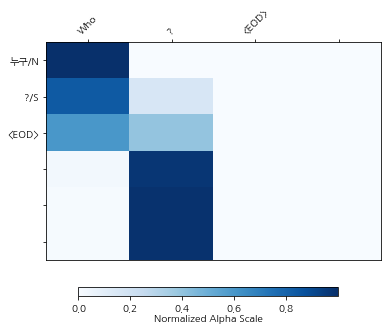

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


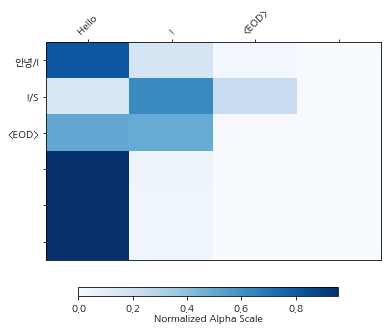

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


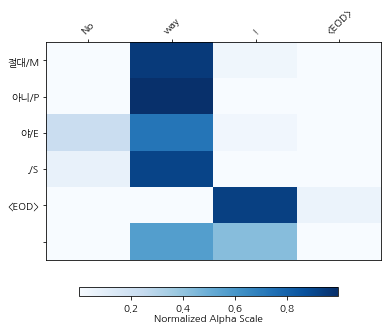

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


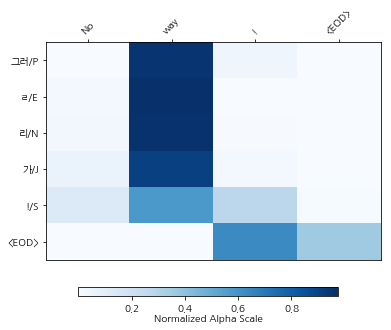

Epoch  80/200 Batch    0/227 - Loss:  0.338
[[[1.27804425e-11 9.54768711e-06 3.22256412e-04 9.03935015e-01
   9.57100764e-02 2.29366724e-05 2.60222488e-09 6.67866402e-08
   0.00000000e+00 0.00000000e+00]
  [1.73280314e-11 1.72255022e-05 7.66674872e-04 9.94533658e-01
   4.68174508e-03 1.35315943e-07 6.01662066e-07 2.76343427e-11
   2.03892874e-17 4.98634962e-17]
  [1.01166370e-04 1.25517370e-03 9.96709228e-01 1.92522840e-03
   9.18705791e-06 4.34268124e-08 1.43036283e-09 1.15146311e-14
   1.22265733e-15 0.00000000e+00]
  [1.00270041e-08 2.40290508e-01 7.59684026e-01 2.54038878e-05
   7.38757037e-13 4.34016495e-12 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[7.85399740e-13 1.63102030e-08 2.69610086e-06 7.21264064e-01
   2.77996212e-01 7.36989081e-04 7.05116747e-08 1.64976495e-08
   0.00000000e+00 0.00000000e+00]
  [1.76243429e-08 1.01154693e-03 3.07435199e-04 5.49584474e-05
   3.17236155e-01 7.89337140e-03 5.78835130e-01 9.37070623e-02
   9.52627743e-04 1.59208412

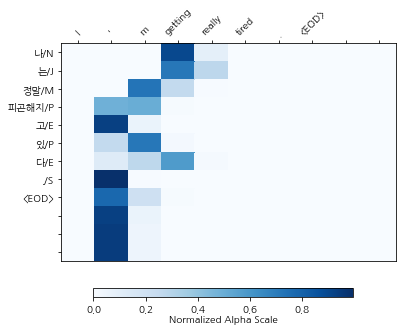

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


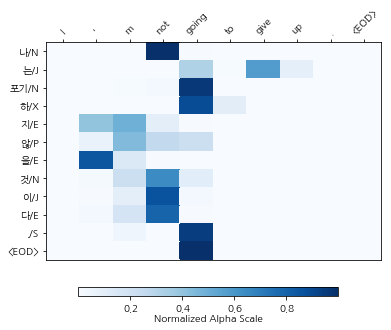

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


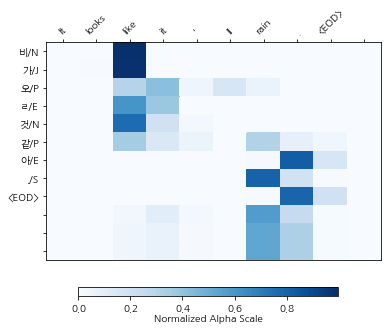

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


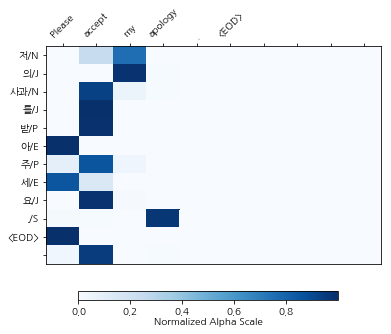

Epoch  80/200 Batch  100/227 - Loss:  0.055
[[[9.09202936e-05 1.71135529e-03 1.71657223e-02 9.80358481e-01
   5.53290942e-04 9.17826910e-05 2.36010528e-05 4.93529706e-06
   4.05332712e-10 8.51254505e-13 2.63906865e-11 7.60104666e-14
   8.22543802e-13]
  [1.80020113e-11 1.45663481e-08 1.00000000e+00 6.85443169e-09
   1.47440247e-14 2.45006440e-15 6.59155108e-21 4.48509354e-22
   1.90177963e-18 9.45031535e-22 1.47006293e-19 0.00000000e+00
   0.00000000e+00]
  [7.13746284e-10 3.66962013e-05 9.98435199e-01 1.50389795e-03
   2.43062750e-05 2.32830172e-10 1.71514034e-16 6.61464827e-10
   1.20668813e-11 3.24893073e-18 1.32315366e-18 0.00000000e+00
   0.00000000e+00]
  [9.99784529e-01 2.15188018e-04 2.08199836e-07 1.42549072e-13
   1.46826263e-17 5.66897053e-20 1.98038292e-23 8.67325448e-26
   4.72102652e-31 2.17078993e-30 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[4.66554775e-05 8.23866650e-02 1.26556769e-01 7.78225362e-01
   7.53829535e-03 2.47581891e-04 5.69911208e-04 4.29546135e

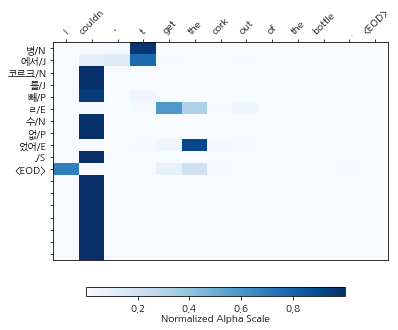

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


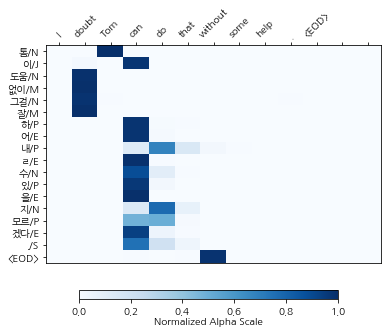

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


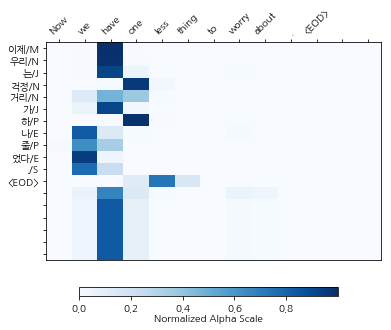

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


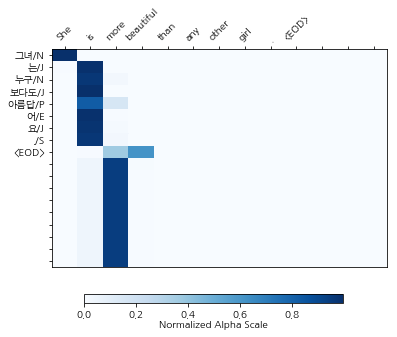

Epoch  80/200 Batch  200/227 - Loss:  0.297
Train perplexity: 1.14310
Epoch  81/200 Batch    0/227 - Loss:  0.165
Epoch  81/200 Batch  100/227 - Loss:  0.012
Epoch  81/200 Batch  200/227 - Loss:  0.090
Train perplexity: 1.14203
Epoch  82/200 Batch    0/227 - Loss:  0.321
Epoch  82/200 Batch  100/227 - Loss:  0.007
Epoch  82/200 Batch  200/227 - Loss:  0.335
Train perplexity: 1.12952
Epoch  83/200 Batch    0/227 - Loss:  0.169
Epoch  83/200 Batch  100/227 - Loss:  0.011
Epoch  83/200 Batch  200/227 - Loss:  0.006
Train perplexity: 1.10469
Epoch  84/200 Batch    0/227 - Loss:  0.299
Epoch  84/200 Batch  100/227 - Loss:  0.081
Epoch  84/200 Batch  200/227 - Loss:  0.014
Train perplexity: 1.09998
Epoch  85/200 Batch    0/227 - Loss:  0.511
Epoch  85/200 Batch  100/227 - Loss:  0.002
Epoch  85/200 Batch  200/227 - Loss:  0.015
Train perplexity: 1.09544
Epoch  86/200 Batch    0/227 - Loss:  0.203
Epoch  86/200 Batch  100/227 - Loss:  0.012
Epoch  86/200 Batch  200/227 - Loss:  0.102
Train pe

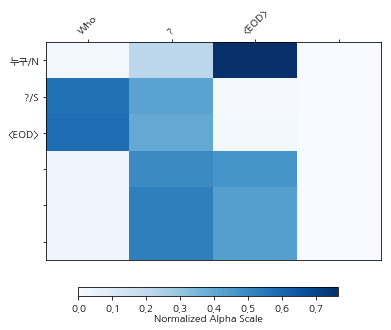

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


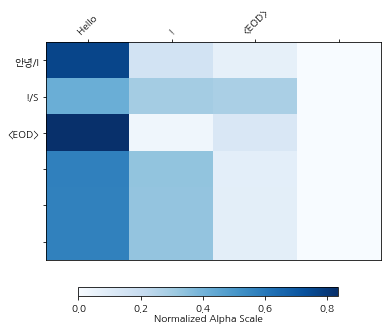

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


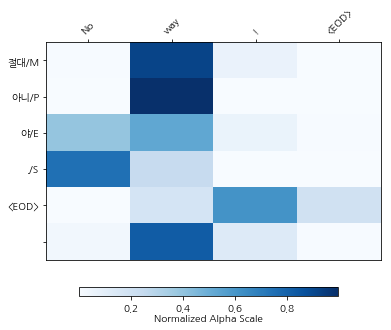

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


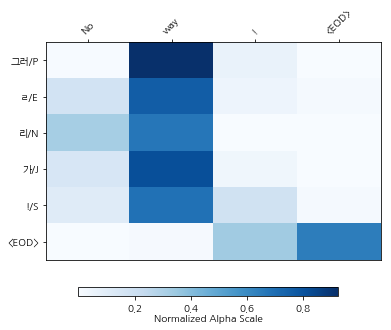

Epoch 100/200 Batch    0/227 - Loss:  0.114
[[[1.61847744e-10 3.08132172e-07 2.29193065e-05 9.29893374e-01
   7.00821653e-02 1.16167939e-06 5.46878584e-11 2.20690202e-11
   0.00000000e+00 0.00000000e+00]
  [1.69348709e-06 3.50249419e-03 3.57326120e-01 6.12922430e-01
   2.27452740e-02 3.12762451e-03 3.46097397e-04 2.82742731e-05
   1.10324161e-09 1.35647847e-11]
  [3.53226881e-03 9.66785401e-02 8.99754941e-01 3.41574851e-05
   2.91477154e-08 2.51157251e-09 6.01941537e-08 4.39132952e-10
   3.08757568e-11 0.00000000e+00]
  [3.43319783e-07 7.42439404e-02 8.92767608e-01 3.29846814e-02
   3.36266612e-06 1.31253461e-08 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[2.08435821e-11 6.22219209e-09 1.37330028e-06 8.24580491e-01
   1.75418049e-01 1.02007952e-07 5.47348833e-09 3.72913991e-11
   0.00000000e+00 0.00000000e+00]
  [3.23720269e-06 1.19048182e-03 1.00416467e-02 4.66488767e-03
   9.77980137e-01 5.50788071e-04 5.52037824e-03 1.64411431e-05
   3.19321334e-05 1.05347901

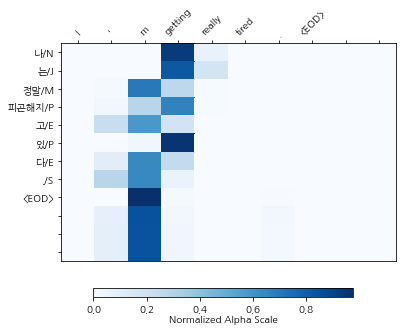

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


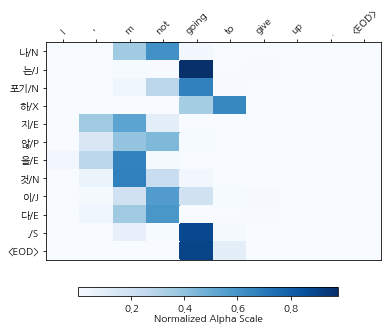

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


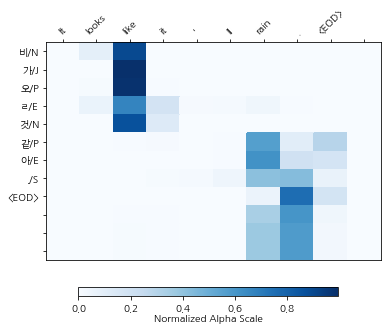

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


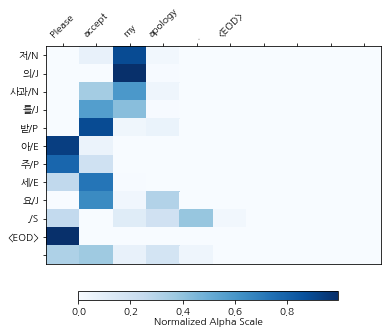

Epoch 100/200 Batch  100/227 - Loss:  0.148
[[[7.22289085e-04 7.48714730e-02 9.15270388e-01 9.09126829e-03
   9.86628947e-06 2.23128097e-07 2.43325449e-05 1.01046071e-05
   1.70231527e-08 2.43802270e-11 2.37441733e-10 3.64068758e-12
   2.95702547e-12]
  [1.05228068e-07 9.98824894e-01 1.17289030e-03 2.03139530e-06
   1.06424762e-08 3.41842887e-10 5.98636321e-13 5.23384978e-14
   1.74483383e-14 6.06814827e-16 2.08912016e-15 0.00000000e+00
   0.00000000e+00]
  [7.75604558e-09 6.67640357e-04 9.99138236e-01 1.87819431e-04
   6.26528845e-06 4.99497735e-11 3.15449793e-17 1.89378223e-16
   7.54960135e-17 2.27127521e-18 1.06494308e-19 0.00000000e+00
   0.00000000e+00]
  [9.99681950e-01 3.13854398e-04 3.95380266e-06 2.27222060e-07
   2.93572083e-10 2.05910608e-10 5.76825089e-12 1.80098713e-16
   1.23952791e-17 1.77657921e-16 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[3.57176759e-08 9.99863744e-01 4.23899328e-05 3.11561453e-05
   2.02366591e-05 2.09039331e-06 3.85353887e-05 1.85065289e

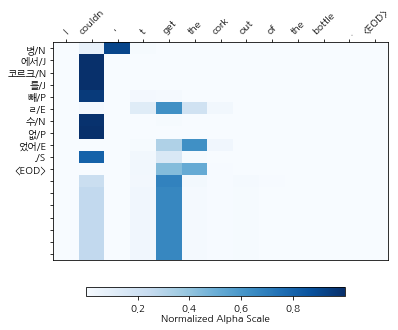

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


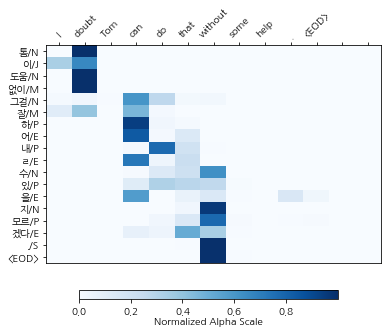

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


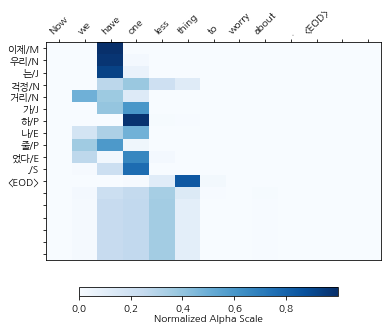

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


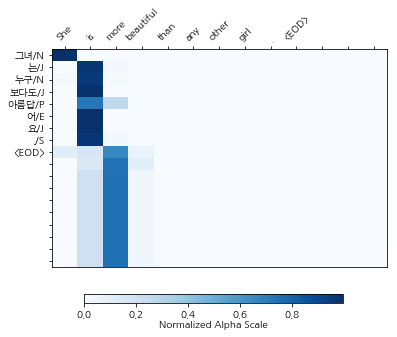

Epoch 100/200 Batch  200/227 - Loss:  0.341
Train perplexity: 1.21425
Epoch 101/200 Batch    0/227 - Loss:  0.254
Epoch 101/200 Batch  100/227 - Loss:  0.154
Epoch 101/200 Batch  200/227 - Loss:  0.141
Train perplexity: 1.17670
Epoch 102/200 Batch    0/227 - Loss:  0.488
Epoch 102/200 Batch  100/227 - Loss:  0.192
Epoch 102/200 Batch  200/227 - Loss:  0.178
Train perplexity: 1.13967
Epoch 103/200 Batch    0/227 - Loss:  0.563
Epoch 103/200 Batch  100/227 - Loss:  0.276
Epoch 103/200 Batch  200/227 - Loss:  0.298
Train perplexity: 1.11581
Epoch 104/200 Batch    0/227 - Loss:  0.641
Epoch 104/200 Batch  100/227 - Loss:  0.020
Epoch 104/200 Batch  200/227 - Loss:  0.013
Train perplexity: 1.09006
Epoch 105/200 Batch    0/227 - Loss:  0.269
Epoch 105/200 Batch  100/227 - Loss:  0.005
Epoch 105/200 Batch  200/227 - Loss:  0.002
Train perplexity: 1.07923
Epoch 106/200 Batch    0/227 - Loss:  0.254
Epoch 106/200 Batch  100/227 - Loss:  0.062
Epoch 106/200 Batch  200/227 - Loss:  0.163
Train pe

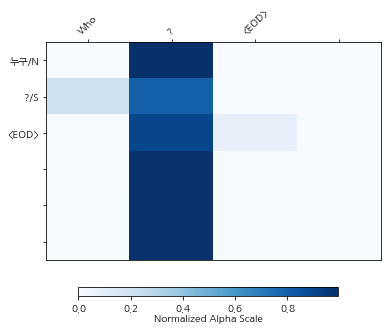

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


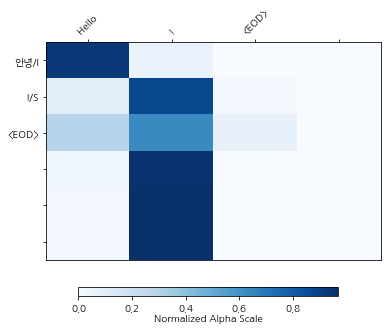

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


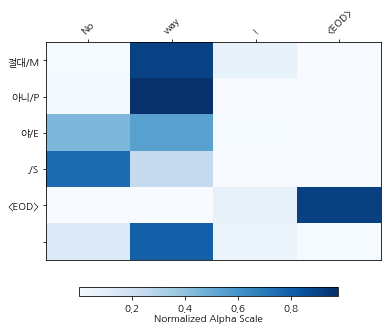

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


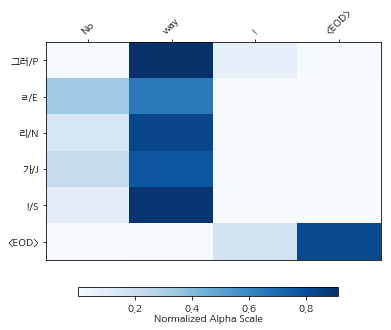

Epoch 120/200 Batch    0/227 - Loss:  0.238
[[[3.82215396e-04 3.50192636e-02 4.74482141e-02 8.48422527e-01
   6.35018051e-02 4.97422973e-03 1.06805106e-04 1.44948135e-04
   0.00000000e+00 0.00000000e+00]
  [1.36737424e-06 4.99423826e-03 4.34342697e-02 9.48229074e-01
   3.31417681e-03 2.53540911e-05 1.50171240e-06 1.58269273e-08
   2.93072483e-10 2.35126835e-10]
  [1.25572592e-08 1.61437507e-04 9.14047420e-01 8.57902318e-02
   8.83374469e-07 3.03827818e-12 8.94825338e-13 1.05215736e-17
   3.71390395e-19 0.00000000e+00]
  [1.47918967e-04 9.99738514e-01 1.13598078e-04 1.99403871e-08
   2.84441377e-18 1.68050262e-25 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[6.17753585e-07 1.68030419e-05 8.51936784e-05 8.68340611e-01
   1.31425053e-01 1.31665714e-04 3.51230405e-08 1.84829563e-09
   0.00000000e+00 0.00000000e+00]
  [2.90133312e-06 3.25427786e-03 2.41609849e-03 5.17468201e-04
   8.97472203e-01 3.37161161e-02 6.25223964e-02 9.80353580e-05
   5.13552038e-07 2.45474063

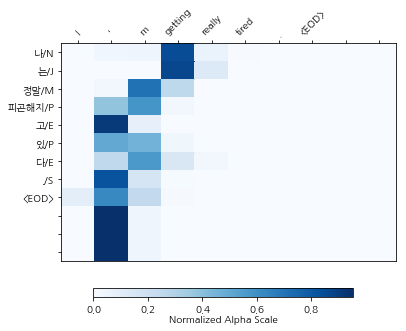

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


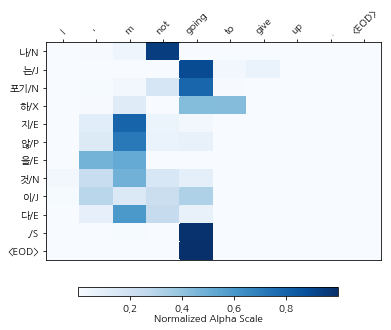

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


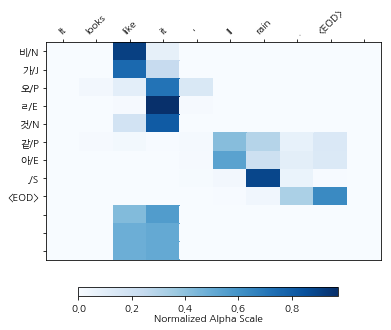

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


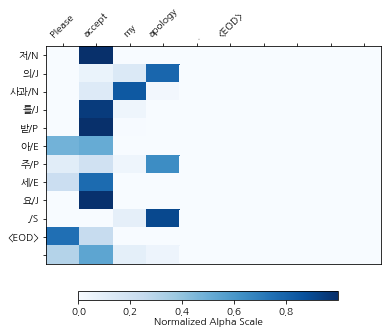

Epoch 120/200 Batch  100/227 - Loss:  0.010
[[[4.04254570e-06 8.89400065e-01 3.97281349e-02 7.00085461e-02
   7.34115485e-04 4.30316286e-05 8.11206919e-05 9.28519228e-07
   1.80512028e-09 4.06158484e-12 3.03873289e-12 7.10847613e-13
   1.60099429e-12]
  [2.66495476e-06 2.23001756e-04 9.99378324e-01 3.93741066e-04
   3.96505527e-07 1.85156694e-06 4.02726874e-09 4.48829307e-11
   4.94802495e-13 1.11877640e-12 3.40893302e-13 0.00000000e+00
   0.00000000e+00]
  [1.93664462e-08 9.00873099e-04 9.94851887e-01 2.37291190e-03
   1.87421753e-03 1.72394934e-07 3.61859431e-10 1.97396210e-10
   1.35776633e-12 4.47829219e-13 1.74224215e-13 0.00000000e+00
   0.00000000e+00]
  [9.99997854e-01 2.18456421e-06 4.73151935e-08 7.70897304e-11
   1.41522150e-11 1.33774081e-09 3.96097738e-12 9.31768971e-14
   2.65005276e-17 2.13599236e-16 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[8.90090860e-07 9.97846723e-01 9.04112967e-05 1.87929044e-03
   1.23310470e-04 1.23975205e-05 3.32805103e-05 1.34246184e

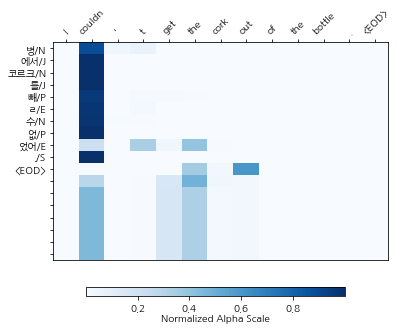

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


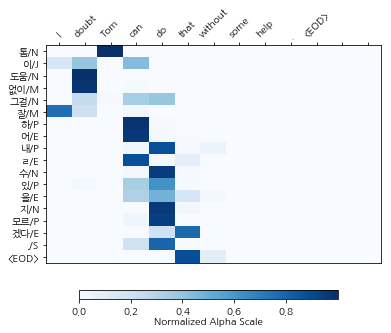

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


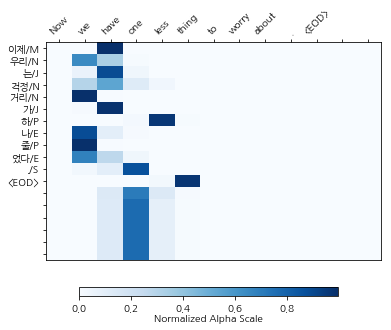

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


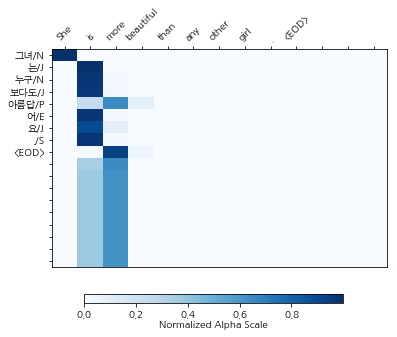

Epoch 120/200 Batch  200/227 - Loss:  0.008
Train perplexity: 1.10772
Epoch 121/200 Batch    0/227 - Loss:  0.142
Epoch 121/200 Batch  100/227 - Loss:  0.014
Epoch 121/200 Batch  200/227 - Loss:  0.058
Train perplexity: 1.11593
Epoch 122/200 Batch    0/227 - Loss:  0.407
Epoch 122/200 Batch  100/227 - Loss:  0.064
Epoch 122/200 Batch  200/227 - Loss:  0.129
Train perplexity: 1.17249
Epoch 123/200 Batch    0/227 - Loss:  0.336
Epoch 123/200 Batch  100/227 - Loss:  0.017
Epoch 123/200 Batch  200/227 - Loss:  0.038
Train perplexity: 1.13296
Epoch 124/200 Batch    0/227 - Loss:  0.170
Epoch 124/200 Batch  100/227 - Loss:  0.013
Epoch 124/200 Batch  200/227 - Loss:  0.009
Train perplexity: 1.13862
Epoch 125/200 Batch    0/227 - Loss:  0.229
Epoch 125/200 Batch  100/227 - Loss:  0.115
Epoch 125/200 Batch  200/227 - Loss:  0.105
Train perplexity: 1.13497
Epoch 126/200 Batch    0/227 - Loss:  0.334
Epoch 126/200 Batch  100/227 - Loss:  0.017
Epoch 126/200 Batch  200/227 - Loss:  0.108
Train pe

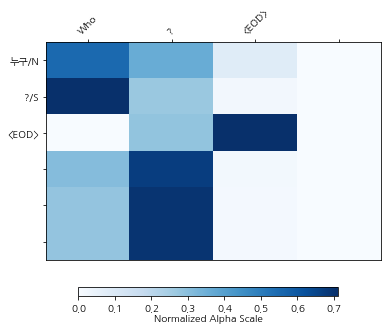

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


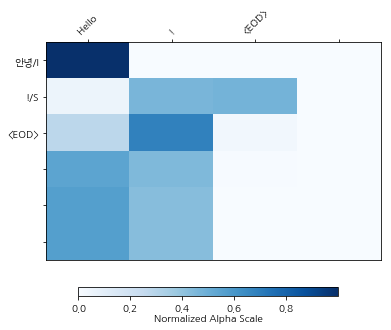

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


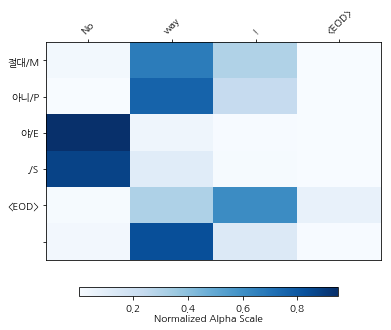

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


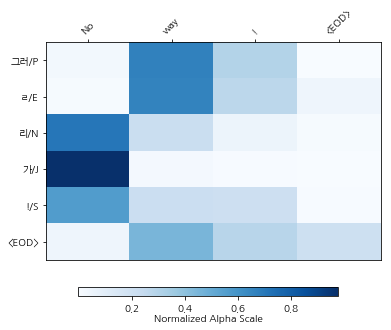

Epoch 140/200 Batch    0/227 - Loss:  0.347
[[[6.43571298e-07 5.11498051e-03 4.25263047e-02 8.32942605e-01
   1.19394779e-01 2.06281402e-05 6.54408971e-09 6.03438437e-08
   0.00000000e+00 0.00000000e+00]
  [4.74940798e-08 3.28683847e-04 4.24232818e-02 8.66270661e-01
   9.09599215e-02 1.69867744e-05 4.24400326e-07 1.74174613e-08
   5.98252073e-11 3.80191850e-10]
  [1.39564316e-08 1.12882808e-04 9.99459088e-01 4.27927473e-04
   5.84489734e-10 4.64426279e-17 3.36798320e-15 1.16608988e-16
   7.13482917e-17 0.00000000e+00]
  [3.57906312e-01 6.07047975e-01 3.50456163e-02 8.19953954e-08
   2.80639040e-10 2.56338006e-10 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[1.73391498e-07 2.10028043e-06 5.93105506e-05 9.90588784e-01
   9.34350491e-03 5.99109035e-06 1.49088990e-07 7.37578887e-10
   0.00000000e+00 0.00000000e+00]
  [1.30581453e-01 3.28502059e-01 5.80371246e-02 3.99819901e-03
   8.11332315e-02 6.91264053e-04 9.79765579e-02 2.73485005e-01
   2.55875513e-02 7.49182391

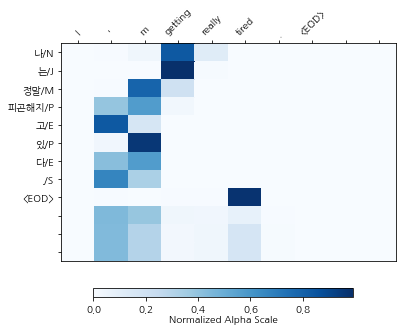

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


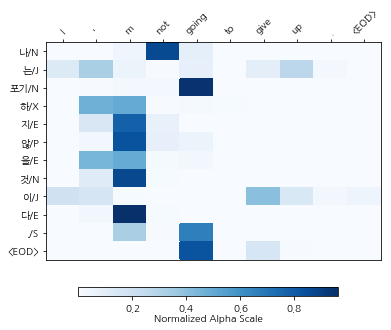

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


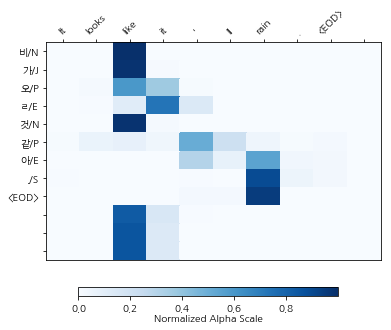

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


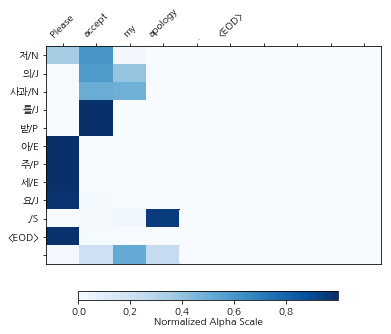

Epoch 140/200 Batch  100/227 - Loss:  0.213
[[[7.74024684e-08 1.75853333e-04 1.88952640e-01 8.10725212e-01
   1.07179956e-04 3.41564737e-06 3.49687216e-05 6.94815583e-07
   2.06461492e-09 1.50549045e-10 8.26360248e-13 3.42990111e-12
   6.38976328e-12]
  [2.18985747e-06 1.52788387e-04 9.99844909e-01 1.47692859e-07
   4.25298463e-09 4.80953810e-09 1.74725553e-10 8.37576449e-12
   1.47971722e-11 1.04893931e-13 4.76914352e-13 0.00000000e+00
   0.00000000e+00]
  [4.88449559e-13 8.28753954e-08 9.99620199e-01 3.79487377e-04
   9.03040558e-08 1.49884738e-09 4.87024375e-13 2.56773682e-12
   9.70893050e-15 8.68086679e-18 9.86621082e-18 0.00000000e+00
   0.00000000e+00]
  [7.74516284e-01 7.42634817e-04 1.90169099e-04 1.16034033e-04
   6.09869487e-04 1.96563631e-01 2.71662883e-02 9.22207764e-05
   3.16505322e-07 2.65740596e-06 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[3.42785357e-03 9.55512881e-01 4.68824431e-03 6.17248518e-03
   5.57716517e-03 3.32686352e-03 1.32653043e-02 7.72050489e

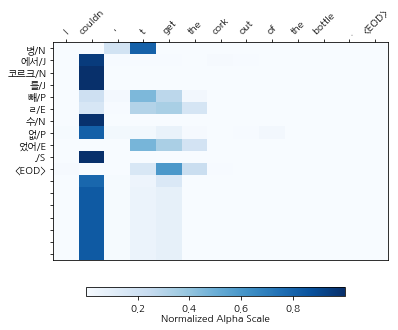

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


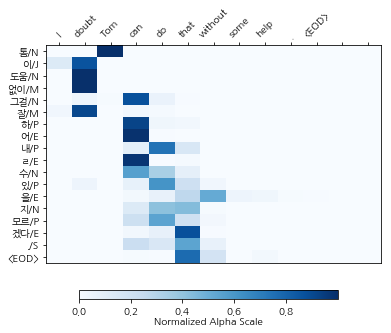

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


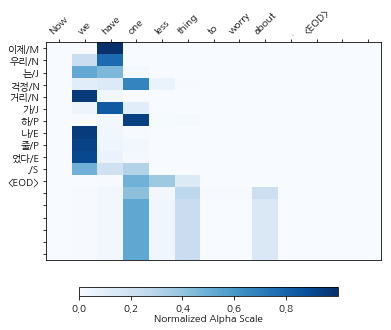

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


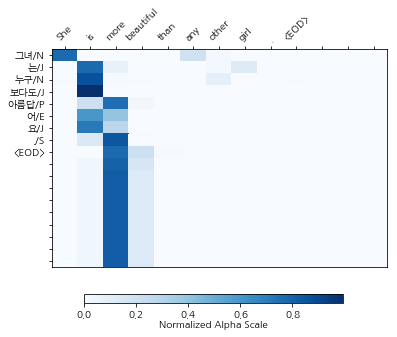

Epoch 140/200 Batch  200/227 - Loss:  0.037
Train perplexity: 1.11479
Epoch 141/200 Batch    0/227 - Loss:  0.179
Epoch 141/200 Batch  100/227 - Loss:  0.606
Epoch 141/200 Batch  200/227 - Loss:  0.016
Train perplexity: 1.10768
Epoch 142/200 Batch    0/227 - Loss:  0.162
Epoch 142/200 Batch  100/227 - Loss:  0.323
Epoch 142/200 Batch  200/227 - Loss:  0.004
Train perplexity: 1.12011
Epoch 143/200 Batch    0/227 - Loss:  0.193
Epoch 143/200 Batch  100/227 - Loss:  0.054
Epoch 143/200 Batch  200/227 - Loss:  0.012
Train perplexity: 1.14066
Epoch 144/200 Batch    0/227 - Loss:  0.201
Epoch 144/200 Batch  100/227 - Loss:  0.154
Epoch 144/200 Batch  200/227 - Loss:  0.018
Train perplexity: 1.14932
Epoch 145/200 Batch    0/227 - Loss:  0.224
Epoch 145/200 Batch  100/227 - Loss:  0.006
Epoch 145/200 Batch  200/227 - Loss:  0.021
Train perplexity: 1.11402
Epoch 146/200 Batch    0/227 - Loss:  0.364
Epoch 146/200 Batch  100/227 - Loss:  0.100
Epoch 146/200 Batch  200/227 - Loss:  0.016
Train pe

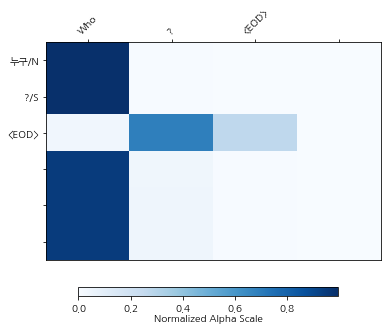

input: Hello ! <EOD>
gener: 안녕/I !/S <EOD>


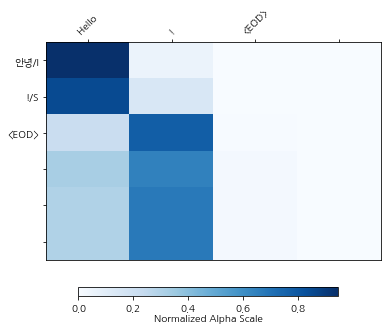

input: No way ! <EOD>
gener: 절대/M 아니/P 야/E ./S <EOD>


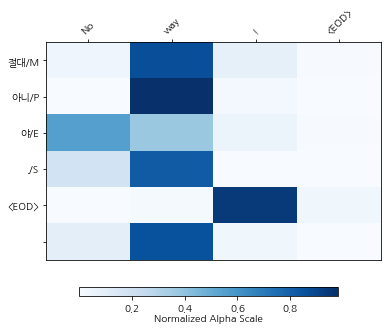

input: No way ! <EOD>
gener: 그러/P ㄹ/E 리/N 가/J !/S <EOD>


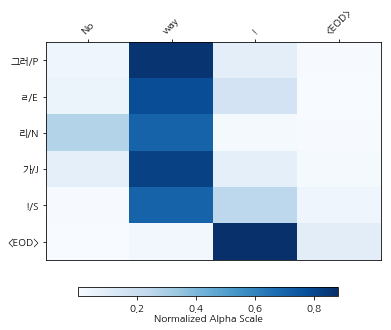

Epoch 160/200 Batch    0/227 - Loss:  0.385
[[[2.34420509e-06 7.42989965e-03 5.40138483e-02 9.26163673e-01
   1.18598342e-02 4.51384898e-04 1.46282173e-05 6.44062820e-05
   0.00000000e+00 0.00000000e+00]
  [5.26147119e-07 8.35649204e-03 9.04846191e-01 8.21464360e-02
   4.64884890e-03 1.00307011e-06 4.34209085e-07 1.78499313e-08
   8.15014722e-12 1.34593552e-11]
  [1.29143067e-04 8.77370089e-02 9.07535255e-01 4.59812721e-03
   4.34789854e-07 1.00749985e-10 2.51711568e-10 3.19474671e-13
   5.26386226e-13 0.00000000e+00]
  [3.09592324e-05 6.20405152e-02 9.37361896e-01 4.96384338e-04
   6.98234871e-05 5.01789032e-07 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.49809352e-06 6.11700261e-06 1.86361896e-04 9.99778807e-01
   2.51455676e-05 7.10705095e-09 1.74194256e-10 7.82577128e-12
   0.00000000e+00 0.00000000e+00]
  [2.63453781e-04 4.38087045e-05 2.24634059e-05 8.05322488e-04
   2.94641815e-02 6.88638091e-02 8.84793997e-01 1.55085269e-02
   2.32478065e-04 1.98173348

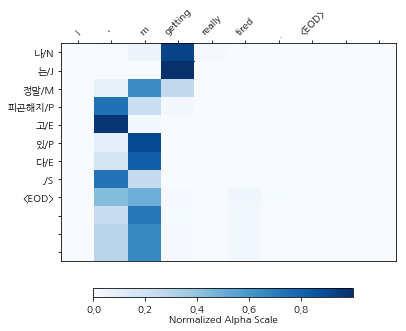

input: I ' m not going to give up . <EOD>
gener: 나/N 는/J 포기/N 하/X 지/E 않/P 을/E 것/N 이/J 다/E ./S <EOD>


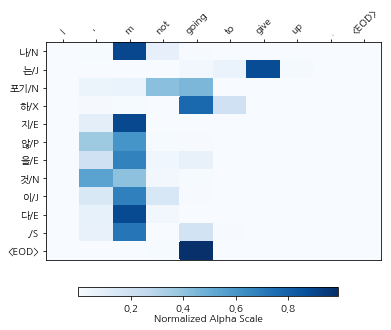

input: It looks like it ' ll rain . <EOD>
gener: 비/N 가/J 오/P ㄹ/E 것/N 같/P 아/E ./S <EOD>


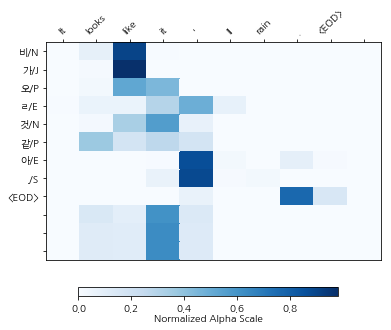

input: Please accept my apology . <EOD>
gener: 저/N 의/J 사과/N 를/J 받/P 아/E 주/P 세/E 요/J ./S <EOD>


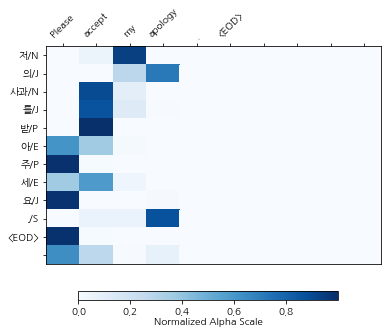

Epoch 160/200 Batch  100/227 - Loss:  0.151
[[[8.51514051e-06 4.30333793e-01 5.51395416e-01 1.82452854e-02
   1.53503370e-05 3.25266143e-07 1.29406180e-06 3.86560650e-08
   3.94798472e-10 1.87857160e-11 4.69124357e-11 2.00663894e-13
   1.82443730e-12]
  [4.76194196e-04 2.85191520e-04 9.97995615e-01 1.21872057e-03
   1.01375263e-05 1.38955384e-05 1.79290964e-07 1.75131316e-11
   2.89574423e-11 7.56721996e-13 1.06791529e-11 0.00000000e+00
   0.00000000e+00]
  [5.56832980e-09 1.70339558e-06 9.99929070e-01 6.86555286e-05
   5.60143235e-07 6.52632721e-08 8.85905516e-11 2.62842215e-09
   5.89880055e-12 1.88541720e-15 2.29617143e-15 0.00000000e+00
   0.00000000e+00]
  [9.99999881e-01 1.07696451e-07 1.24765211e-08 4.32727354e-10
   2.66012989e-10 6.98528790e-10 2.85709841e-11 1.53064708e-13
   2.09801845e-15 2.36952597e-15 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[7.60269904e-06 8.17285419e-01 3.90305519e-02 1.31248921e-01
   6.07756432e-03 3.82593571e-04 5.08323777e-03 7.51968822e

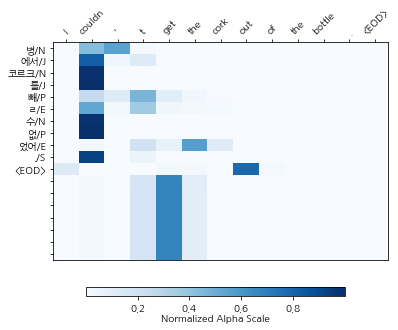

input: I doubt Tom can do that without some help . <EOD>
gener: 톰/N 이/J 도움/N 없이/M 그걸/N 잘/M 하/P 어/E 내/P ㄹ/E 수/N 있/P 을/E 지/N 모르/P 겠다/E ./S <EOD>


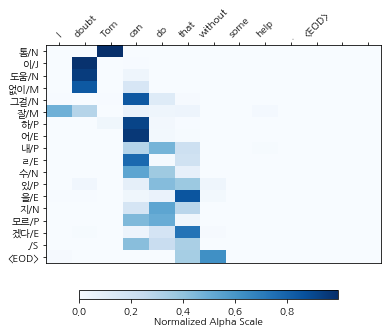

input: Now we have one less thing to worry about . <EOD>
gener: 이제/M 우리/N 는/J 걱정/N 거리/N 가/J 하/P 나/E 줄/P 었다/E ./S <EOD>


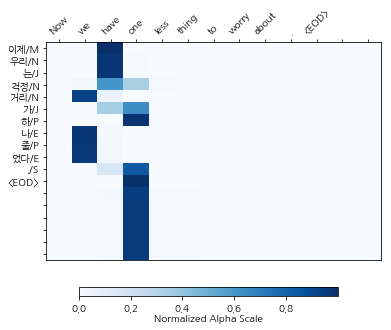

input: She is more beautiful than any other girl . <EOD>
gener: 그녀/N 는/J 누구/N 보다도/J 아름답/P 어/E 요/J ./S <EOD>


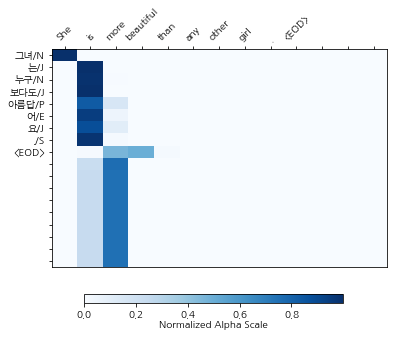

Epoch 160/200 Batch  200/227 - Loss:  0.026
Train perplexity: 1.11580
Epoch 161/200 Batch    0/227 - Loss:  0.299
Epoch 161/200 Batch  100/227 - Loss:  0.047
Epoch 161/200 Batch  200/227 - Loss:  0.159
Train perplexity: 1.11148
Epoch 162/200 Batch    0/227 - Loss:  0.295
Epoch 162/200 Batch  100/227 - Loss:  0.007
Epoch 162/200 Batch  200/227 - Loss:  0.007
Train perplexity: 1.11803
Epoch 163/200 Batch    0/227 - Loss:  0.140
Epoch 163/200 Batch  100/227 - Loss:  0.028
Epoch 163/200 Batch  200/227 - Loss:  0.021
Train perplexity: 1.12740
Epoch 164/200 Batch    0/227 - Loss:  0.106
Epoch 164/200 Batch  100/227 - Loss:  0.061
Epoch 164/200 Batch  200/227 - Loss:  0.007
Train perplexity: 1.09460
Epoch 165/200 Batch    0/227 - Loss:  0.202
Epoch 165/200 Batch  100/227 - Loss:  0.194
Epoch 165/200 Batch  200/227 - Loss:  0.033
Train perplexity: 1.09076
Epoch 166/200 Batch    0/227 - Loss:  0.242
Epoch 166/200 Batch  100/227 - Loss:  0.010


KeyboardInterrupt: 

In [31]:
import time
import numpy as np
from __future__ import unicode_literals

display_step = 100
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'

test_step = 20

_att = []

with tf.Session (graph = tf_graph, config=config) as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    
    flag = False
    for epoch_i in range(0, epochs+1):
        _tcosts = []
        for batch_i, (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                            target_sent_ids,
                                                                                                            batch_size,
                                                                                                             voca_e_to_int[PAD],
                                                                                                             voca_k_to_int[PAD]
                                                                                                            )):
            
            if batch_i % display_step == 0 and epoch_i%test_step==0:
                _, loss, attention = sess.run([train_op, cost, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
                _att = attention
                print(_att)
                

                for ans_i in range(batch_size):
                    ans = targets_batch[ans_i]
                    _ans = ""
                    for v in ans:
                        if v == voca_k_to_int[EOD]:

                            _ans += int_to_voca_k[v]
                            break
                        else:

                            _ans += int_to_voca_k[v]+" "



                    org = sources_batch[ans_i]
                    _org = ""
                    for v in org:
                        if v == voca_e_to_int[EOD]:
                            _org += int_to_voca_e[v]
                            break
                        else:
                            _org += int_to_voca_e[v]+" "

                    print("input: {}".format(_org))
                    print("gener: {}".format(_ans))
                    my_plot(attention[:, ans_i, :], _org.split(), _ans.split())
                #print(_att)                
                
            else:
                _, loss = sess.run([train_op, cost], feed_dict={input_data: sources_batch,
                                                     targets: targets_batch,
                                                     lr: learning_rate,
                                                     target_sequence_length: target_lengths,
                                                     source_sequence_length: source_lengths})
            

            
            _tcosts.append(loss)
            
            #print(batch_i, loss)
            
            if batch_i % display_step == 0:
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}'.format(epoch_i, 
                                                                              epochs,
                                                                              batch_i,
                                                                              len(source_sent_ids)//batch_size,
                                                                              loss))  
               
            #print(sources_batch)
            
        
        print('Train perplexity: {:>6.5f}'.format(np.exp(np.mean(_tcosts))))
        
        '''
        if epoch_i%test_step == 0:
            (sources_batch, targets_batch, source_lengths, target_lengths) in enumerate(get_batches(source_sent_ids,
                                                                                                   target_sent_ids,
                                                                                                   batch_size,
                                                                                                   voca_e_to_int[PAD],
                                                                                                   voca_k_to_int[PAD]))
            answer_logits, attention = sess.run([inference_logits, training_decoder_state.alignment_history.stack()], feed_dict={input_data: sources_batch,
                                                       targets: targets_batch,
                                                        target_sequence_length: target_lengths,source_sequence_length: source_lengths})
        
            for ans_i in range(len(answer_logits)):
                ans = np.transpose(answer_logits[ans_i]).tolist()
                _ans = ""
                for v in ans:
                    if v == voca_k_to_int[EOD]:
                        
                        _ans += int_to_voca_k[v]
                        break
                    else:
                        
                        _ans += int_to_voca_k[v]+" "
                        
                
                
                org = sources_batch[ans_i]
                _org = ""
                for v in org:
                    if v == voca_e_to_int[EOD]:
                        _org += int_to_voca_e[v]
                        break
                    else:
                        _org += int_to_voca_e[v]+" "
                        
                print("input: {}".format(_org))
                print("gener: {}".format(_ans))
                my_plot(attention[:, ans_i, :source_lengths[ans_i]], _org.split(), _ans.split())
        '''
        #break
    run_time = time.time() - start_time
    print('Run Time : %s seconds' %(run_time))

In [30]:
print(batch_size)
print(len(_att), len(_att[0,:,:]), len(_att[:, 0, :]), len(_att[:, :, 0]))
print(_att)


16
7 16 7 7
[[[0.33343878 0.3332922  0.33326903 0.         0.         0.        ]
  [0.33336186 0.3333806  0.33325756 0.         0.         0.        ]
  [0.25013822 0.24988881 0.24990554 0.25006747 0.         0.        ]
  [0.25013688 0.25013605 0.24981354 0.24991348 0.         0.        ]
  [0.33331153 0.3333761  0.33331236 0.         0.         0.        ]
  [0.16672722 0.16668999 0.16670161 0.16653372 0.16670887 0.16663855]
  [0.20021477 0.20005678 0.19991048 0.19987218 0.19994581 0.        ]
  [0.3334753  0.33319205 0.33333272 0.         0.         0.        ]
  [0.24986565 0.25009865 0.2499379  0.25009772 0.         0.        ]
  [0.33329123 0.33342668 0.33328205 0.         0.         0.        ]
  [0.3333457  0.3333357  0.33331862 0.         0.         0.        ]
  [0.2497865  0.25017434 0.24996549 0.25007364 0.         0.        ]
  [0.24990506 0.25016525 0.24994993 0.24997978 0.         0.        ]
  [0.16675521 0.16662984 0.1665238  0.16659883 0.16684759 0.16664474]
  [0.249

In [38]:
pair_kor[0:8]

[['누구/N', '?/S', '<EOD>'],
 ['안녕/I', '!/S', '<EOD>'],
 ['절대/M', '아니/P', '야/E', './S', '<EOD>'],
 ['그러/P', 'ㄹ/E', '리/N', '가/J', '!/S', '<EOD>'],
 ['안녕/I', '!/S', '<EOD>'],
 ['슬프/P', '어/E', './S', '<EOD>'],
 ['나/N', '도/J', './S', '<EOD>'],
 ['완벽/N', '하/X', '어/E', '!/S', '<EOD>']]

In [39]:
pair_eng[0:8]

[['Who', '?', '<EOD>'],
 ['Hello', '!', '<EOD>'],
 ['No', 'way', '!', '<EOD>'],
 ['No', 'way', '!', '<EOD>'],
 ['Goodbye', '!', '<EOD>'],
 ['I', "'", 'm', 'sad', '.', '<EOD>'],
 ['Me', ',', 'too', '.', '<EOD>'],
 ['Perfect', '!', '<EOD>']]

In [40]:
print(_att[:, 0, :])

[[9.9997175e-01 2.8251798e-05 3.8194975e-11 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9996138e-01 3.8599690e-05 5.2705978e-10 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9991572e-01 8.4318490e-05 9.7919788e-09 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9999309e-01 6.9702555e-06 3.7841216e-10 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9999547e-01 4.5833594e-06 1.7807929e-10 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9999547e-01 4.5833594e-06 1.7807929e-10 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [9.9999547e-01 4.5833594e-06 1.7807929e-10 0.0000000e+00 0.0000000e+00
  0.0000000e+00]]


In [140]:
print(attention)

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.6657353e-30
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6688689e-36
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.3934238e-08
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.000